In [1]:
base_dir="/mnt/efs/shared/meg_shared_scripts/meg-kb"
data_ac="indeeda-meg-ac"
data_pt="indeeda-meg-pt"
yutong_base_dir="/home/ubuntu/users/yutong"

In [2]:
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [3]:
from tqdm.notebook import tqdm
import argparse
import re
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, entropy, gmean
import random
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import json
from collections import defaultdict, Counter
import time
import importlib

import logging
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import os
import sys
import math
from annoy import AnnoyIndex
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx

import spacy
from spacy.matcher import Matcher
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
spacy_tokenizer = nlp.tokenizer

nlp_full = spacy.load('en_core_web_sm')

from compute_concept_clusters import knn
from compute_keyphrase_embeddings import ensure_tensor_on_device, mean_pooling

from lm_probes import LMProbe, LMProbe_GPT2, LMProbe_Joint, LMProbe_PMI, LMProbe_PMI_greedy
from utils import load_embeddings, load_seed_aligned_concepts, load_seed_aligned_relations, load_benchmark
from utils import load_EE_labels
from utils import get_masked_contexts, bert_untokenize
from utils import learn_patterns

from roberta_ses.interface import Roberta_SES_Entailment

In [72]:
import utils
importlib.reload(utils)
from utils import load_embeddings, load_seed_aligned_concepts, load_seed_aligned_relations, load_benchmark
from utils import load_EE_labels
from utils import get_masked_contexts, bert_untokenize
from utils import learn_patterns

import lm_probes
importlib.reload(lm_probes)
from lm_probes import LMProbe, LMProbe_GPT2, LMProbe_Joint, LMProbe_PMI, LMProbe_PMI_greedy

In [5]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aux_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts_aux.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
seed_aux_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_aux.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')

# Data Preprocessing

In [2]:
# Input: text corpus
# step 1: extract key phrases (autophrase)
# step 2: generate embeddings

## Extract Key Phrases

In [3]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/keyword_extraction

In [8]:
#change to keyword extractor directory
%cd $base_dir/src/keyword_extraction/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction


In [9]:
!chmod +x ./corpusProcess.sh

In [5]:
# select the dataset and thread no
data_ac = 'indeeda-meg-ac'
data_pt = 'indeeda-meg-pt'
thread = 8

In [ ]:
# process corpus and generate key prhases
!./corpusProcess.sh $data_ac $thread

In [464]:
# copy these results to sample-meg-pt
!cp -r $base_dir/data/$data_ac $base_dir/data/$data_pt

## Corpus with company names

In [33]:
dataset_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/question_answers.csv'
company_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/fccid-companyName.csv'
entity_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
out_corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [161]:
# Use script
!python build_corpus_with_companies.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-rd /home/ubuntu/users/nikita/data/indeed/indeedQA


Processing lines: 100%|████████████████| 307122/307122 [11:31<00:00, 444.12it/s]


In [114]:
!cp $base_dir/data/$data_ac/intermediate/sentences_with_company.json $base_dir/data/$data_pt/intermediate/

# Generate Embeddings

In [465]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [11]:
#change to concept learning directory
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## Sentence Embedding

In [86]:
!CUDA_VISIBLE_DEVICES=2 python compute_keyphrase_embeddings.py \
-m roberta-base \
-et ac \
-ename RoBERTa \
-d $base_dir/data/$data_ac/intermediate \
-c 750

computing entity-wise embedding: 100%|██████| 8028/8028 [04:55<00:00, 27.21it/s]
Saving embedding


## Concatenated Token Embedding

In [ ]:
!CUDA_VISIBLE_DEVICES=3 python compute_keyphrase_embeddings.py -m bert-base-uncased -et pt -d $base_dir/data/$data_pt/intermediate -c 750

## Token Embedding

In [ ]:
# change directory to autophrase
%cd $base_dir/src/tools/AutoPhrase

In [ ]:
data_corel = 'sample-indeeda-corel'

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python extractBertEmbedding.py ../../../data/$data_corel/intermediate/ $thread

## Non-masking Concat Token Embedding

In [68]:
def get_non_masking_avg_context_embeddings(model_path, input_file, max_context_ct,
                                           tokenizer,
                                           model,
                                           ent_context):
    '''
    mean pooling from sentence-transformers
    :param model_path:
    :param input_file:
    :return:
    '''
#     tokenizer = AutoTokenizer.from_pretrained(model_path)
#     model = AutoModel.from_pretrained(model_path)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
    device = "cpu"
    model.eval()
    mask_token_id = tokenizer.mask_token_id

#     ent_freq, ent_context = get_masked_contexts(input_file)
    entity_embeddings = {}
    for entity, en_context_lst in tqdm(ent_context.items(), total=len(ent_context), desc="computing entity-wise embedding"):
        en_context_lst = random.sample(en_context_lst, min(len(en_context_lst), max_context_ct))
        
        entity_toks = tokenizer.tokenize(entity)
        en_non_mask_context_lst = []
        en_span_lst = []
        for _ctx in en_context_lst:
            _nm_ctx = _ctx.replace('[MASK]', entity)
            _ctx_toks = tokenizer.tokenize(_ctx)
            _nm_ctx_toks = tokenizer.tokenize(_nm_ctx)
            try:
                _mask_id = _ctx_toks.index('[MASK]')
                assert _nm_ctx_toks[_mask_id : _mask_id + len(entity_toks)] == entity_toks
            except:
                raise ValueError(_ctx, _ctx_toks)
            en_span_lst.append((_mask_id + 1, _mask_id + len(entity_toks) + 1))  # +1 for [CLS]
            en_non_mask_context_lst.append(_nm_ctx)
            
        # chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
        # print(entity)
        # print(len(en_context_lst))
        all_context_embeddings = []
        for i in range(0, len(en_context_lst), 100):
            chunk = en_non_mask_context_lst[i:i+100]
            en_span_chunk = en_span_lst[i:i+100]
            
            encoded_input = tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
            # mask = encoded_input['input_ids'] != mask_token_id
            mask = torch.zeros_like(encoded_input['input_ids'])
            for j in range(len(en_span_chunk)):
                _s, _e = en_span_chunk[j]
                mask[j, _s:_e] = 1
                print(tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][j, _s:_e]))
    
            with torch.no_grad():
                encoded_input = ensure_tensor_on_device(device, **encoded_input)
                model_output = model(**encoded_input)  # Compute token embeddings
            context_embeddings = mean_pooling(model_output, mask)  # mean pooling
            all_context_embeddings.append(context_embeddings)
        entity_embedding = torch.mean(torch.cat(all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
        print(entity, len(entity_embedding))
        entity_embeddings[entity] = entity_embedding
        
#     return entity_embeddings, ent_freq
    return entity_embeddings

In [64]:
# bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
# entity_embeddings = load_embeddings(bert_emb_path, 768)
# len(entity_embeddings)

In [43]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
_, _all_ent_contexts = get_masked_contexts(corpus_path, embed_num_path)
len(_all_ent_contexts)

7921

In [48]:
_entities = ['walmart', '401k plan', 'saturday / sunday']
_ent_contexts = dict([(_e, _all_ent_contexts[_e]) for _e in _entities])
len(_ent_contexts)

3

In [57]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

In [69]:
_res = get_non_masking_avg_context_embeddings(
    model_path='bert-base-uncased',
    input_file=None,
    max_context_ct=10,
    ent_context=_ent_contexts,
    tokenizer=bert_tokenizer,
    model=bert_model)

['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
['wal', '##mart']
walmart 768
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
['401', '##k', 'plan']
401k plan 768
['saturday', '/', 'sunday']
['saturday', '/', 'sunday']
saturday / sunday 768



In [72]:
# Using script
!CUDA_VISIBLE_DEVICES=3 python compute_keyphrase_embeddings.py -m bert-base-uncased -et nm_ac -d $base_dir/data/$data_ac/intermediate -c 750

computing entity-wise embedding: 100%|██████| 8028/8028 [07:19<00:00, 18.29it/s]
Saving embedding


## Add embeddings for seed instances

In [88]:
# Using script

!CUDA_VISIBLE_DEVICES=2 python add_seed_instances_embeddings.py \
-m roberta-base \
-et ac \
-ename RoBERTa \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-c 750

Seed instances: ['walmart', 'amazon', 'subway', 'microsoft', 'target', 'business casual', 'uniform', 'hair color', 'tattoos', 'facial hair', 'shoes', 'piercings', 'delivery driver', 'store manager', 'cashier', 'package handler', 'sales associate', 'barista', 'dishwasher', 'weekly', 'biweekly', 'friday', 'saturday', 'health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance', 'base pay', 'stock options', 'overtime pay', 'bonus', 'checks', 'direct deposit', 'prepaid card', 'drug test', 'criminal background check', 'employment verification', 'felons', 'criminals', 'disabled', 'drug addicts', 'high schoolers', 'misdemeanor', 'pregnant', 'students', 'seniors', 'hiring age', 'bachelors degree', 'prior experience', 'working permit', 'heavy lifting', 'night shift', 'dinner shift', 'early morning shift', '8 hour shift', 'christmas eve', 'early morning', 'hoilday', '7 days', 'saturday', 'sunday', 'weekend', 'full time', 'part time', 'seasonal', 'orientation

In [ ]:
!CUDA_VISIBLE_DEVICES=3 python add_seed_instances_embeddings.py -m bert-base-uncased -et pt -d $base_dir/data/$data_pt/intermediate -b $base_dir/data/indeed-benchmark -c 750

## Check embeddings

In [121]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed.txt')

embeddings = load_embeddings(bert_emb_path, 768)
len(embeddings)

8028

In [118]:
embeddings[embeddings['entity'] == 'black shirt']

,entity,embedding


# Expand Seed Entities (clustering)

In [99]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [299]:
#change to concept learning directory
%cd ../../concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## knn sentence-embedding

In [365]:
clusters = 100
output = '../../data/'+data_ac+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [366]:
!python compute_concept_clusters.py -d ../../data/$data_ac/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 2001.57it/s]


## knn token concatenated

In [308]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 3072

In [309]:
!python compute_concept_clusters.py -d ../../data/$data_pt/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 4052.00it/s]


## knn token

In [ ]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [ ]:
!python compute_concept_clusters.py -d ../../data/$data_corel/intermediate/ -ca knn -s $clusters -dim $dim -o $output

## Seed instances clustering (EE-emb)
(using all seed instances of a concept to find neighbors)

In [51]:
%cd $base_dir/src/concept_learning

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [52]:
# Use script
cluster_size = None

!python compute_concept_seeds_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/ee_concept_knn_k=None.csv \
-kdt

building entity index: 100%|██████████████| 8064/8064 [00:01<00:00, 6287.40it/s]
finding nearest neighbors by concept: 14it [00:00, 16.42it/s]


In [89]:
!python compute_concept_seeds_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-e $base_dir/data/$data_ac/intermediate/BERTembed_RoBERTa+seeds.txt \
-o $base_dir/data/$data_ac/intermediate/ee_concept_knn_roberta_k=None.csv \
-kdt


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 13.38it/s]


In [ ]:
# check results 
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')

df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'company'].head(10)

In [ ]:
df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'pay_schedule'].head(10)

## Contrastive EE-emb

In [245]:
# Use script
# cluster_size = None

!python compute_concept_contrastive_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_k=None.csv

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 4704.77it/s]


In [56]:
!python compute_concept_contrastive_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-aux_cc \
-o $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn-aux-k=None.csv

100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 5062.75it/s]


## EE-LM-probe (prompt)

In [ ]:
'''
@Nikita: Here are the code blocks for exploring LM prompts for EE.

Some core code:
lm_probe = LMProbe()        // LMProbe: BERT; LMProbe_GPT2: GPT2; etc.
all_entitites = ...         // all the entities
_template = "Dress code like jeans, [MASK] and tattoos." // A string with [MASK] (LMProbe automatically takes care of all entity token lengths, so don't need to duplicate mask tokens)
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))  // Show results (rank, cand, score)

'''

In [75]:
lm_probe = LMProbe(model_name='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
lm_probe_gpt2 = LMProbe_GPT2()

In [ ]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

In [ ]:
_r = 'has_dress_code'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
print(_seed_heads, _seed_tails)

_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
print(len(_cand_heads), len(_cand_tails))

In [33]:
emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
with open(emb_num_path, 'r') as f:
    all_entities = [l.rsplit(' ', 1)[0] for l in f]
len(all_entities), all_entities[:3]

(8064, ['multiple times', 'upper', 'management'])

In [76]:
_template = 'dress code including business casual, uniform, hair color, tattoos, facial hair, shoes, [MASK] and piercings.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:20]))

[(0, {'cand': 'tattoos', 'score': 0.4160754084587097}),
 (1, {'cand': 'hair', 'score': 0.039885014295577996}),
 (2, {'cand': 'lipstick', 'score': 0.02614353969693184}),
 (3, {'cand': 'sunglasses', 'score': 0.012342552654445166}),
 (4, {'cand': 'clothing', 'score': 0.006540362257510425}),
 (5, {'cand': 'jewellery', 'score': 0.006417935248464348}),
 (6, {'cand': 'cosmetics', 'score': 0.00435011088848114}),
 (7, {'cand': 'tattoo', 'score': 0.0035406514070928105}),
 (8, {'cand': 'shoes', 'score': 0.002573060104623437}),
 (9, {'cand': 'jeans', 'score': 0.0015570956747978924}),
 (10, {'cand': 'mascara', 'score': 0.0012895131949335337}),
 (11, {'cand': 'nipples', 'score': 0.001285086153075099}),
 (12, {'cand': 'skin', 'score': 0.0012442303122952583}),
 (13, {'cand': 'logos', 'score': 0.0007056326139718295}),
 (14, {'cand': 'ponytail', 'score': 0.0006706683780066669}),
 (15, {'cand': 'cologne', 'score': 0.0005899472744204106}),
 (16, {'cand': 'handcuffs', 'score': 0.0004861631023231892}),
 (17

In [73]:
lm_probe_roberta = LMProbe(model_name='roberta-base')

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
_template = 'dress code including business casual, uniform, hair color, tattoos, facial hair, shoes, [MASK] and piercings.'
_res = lm_probe_roberta.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:20]))

[(0, {'cand': 'tattoos', 'score': 0.28747424483299255}),
 (1, {'cand': 'clothing', 'score': 0.06236377730965614}),
 (2, {'cand': 'hair', 'score': 0.007582573685795066}),
 (3, {'cand': 'skin', 'score': 0.0070136240683496}),
 (4, {'cand': 'cosmetics', 'score': 0.0054200440645217896}),
 (5, {'cand': 'lipstick', 'score': 0.0037557301111519332}),
 (6, {'cand': 'sunglasses', 'score': 0.0023571669589728117}),
 (7, {'cand': 'labels', 'score': 0.0009628509869799014}),
 (8, {'cand': 'tattoo', 'score': 0.0008015605271793904}),
 (9, {'cand': 'mascara', 'score': 0.0006437317933887245}),
 (10, {'cand': 'jeans', 'score': 0.0004768913495354353}),
 (11, {'cand': 'shoes', 'score': 0.0004637015226762742}),
 (12, {'cand': 'paint', 'score': 0.00046234327601268893}),
 (13, {'cand': 'leather', 'score': 0.0004592324548866599}),
 (14, {'cand': 'design', 'score': 0.0003993592399638145}),
 (15, {'cand': 'products', 'score': 0.0003246380656491965}),
 (16, {'cand': 'bones', 'score': 0.00025791997904889275}),
 (17,

In [58]:
_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [64]:
_tokenizer, _tokenizer.mask_token, _tokenizer.cls_token, _tokenizer.sep_token

(PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}),
 '<mask>',
 '<s>',
 '</s>')

In [60]:
_tokenizer.tokenize(' hair color')

['Ġhair', 'Ġcolor']

In [66]:
_tokenizer.convert_tokens_to_ids(['Ġhair', 'Ġcolor'])

[2549, 3195]

In [67]:
_tokenizer.convert_tokens_to_string(['Ġhair', 'Ġcolor'])

' hair color'

In [65]:
_t = AutoTokenizer.from_pretrained('bert-base-uncased')
_t, _t.mask_token, _t.cls_token, _t.sep_token

(PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 '[MASK]',
 '[CLS]',
 '[SEP]')

In [68]:
_t.convert_tokens_to_string(['hair', 'color'])

'hair color'

In [78]:
# Use scripts 
!python compute_EE_LM_probe.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-lm mlm \
-lm_model roberta-base \
-o $base_dir/data/$data_ac/intermediate/ee_LM_roberta_k=None.csv


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.20s/it]


In [8]:
!python compute_EE_LM_probe.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-lm bert \
-lm_model /home/ubuntu/users/nikita/models/bert_finetuned_lm/indeed_reviews_ques_ans \
-agg avg \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_DA_avg_k=None.csv


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.88s/it]


In [57]:
!python compute_EE_LM_probe.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-lm bert \
-aux_cc \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert-aux-k=None.csv


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████| 28/28 [01:44<00:00,  3.72s/it]


In [271]:
!python compute_EE_LM_probe.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-lm bert \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_k=None.csv


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.82s/it]


## Class name prediction

In [6]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
_input_txt = '[MASK] such as bachelor degree is required to work at Walmart.'
lm_probe.score_candidates(_input_txt, ['benefits', 'roles', 'persons', 'schedules', 'dresses', 'departments', 'checks', 'qualifications'])

[{'cand': 'qualifications', 'score': 0.010107847861945629},
 {'cand': 'benefits', 'score': 1.0626394214341422e-05},
 {'cand': 'roles', 'score': 1.079390585800865e-06},
 {'cand': 'checks', 'score': 5.771184419245406e-07},
 {'cand': 'persons', 'score': 3.987514958225805e-07},
 {'cand': 'departments', 'score': 2.8143759323029387e-07},
 {'cand': 'schedules', 'score': 2.6243087702937383e-08},
 {'cand': 'dresses', 'score': 1.1577242275961901e-08}]

In [28]:
_input_txt = '[MASK] such as bachelor degree is required to work at the company.'
lm_probe.score_candidates(_input_txt, ['benefits', 'roles', 'persons', 'schedules', 'dresses', 'departments', 'checks', 'qualifications'])

[{'cand': 'qualifications', 'score': 0.014812425710260875},
 {'cand': 'benefits', 'score': 9.158307875622997e-06},
 {'cand': 'persons', 'score': 9.146327784037573e-07},
 {'cand': 'roles', 'score': 6.875428653074773e-07},
 {'cand': 'checks', 'score': 2.984555749208085e-07},
 {'cand': 'departments', 'score': 1.602442836201591e-07},
 {'cand': 'dresses', 'score': 8.730975054049843e-09},
 {'cand': 'schedules', 'score': 7.1630932296784555e-09}]

In [25]:
_input_txt = 'They have [MASK] such as bachelor degree.'
lm_probe.score_candidates(_input_txt, ['benefits', 'roles', 'persons', 'schedules', 'dresses', 'departments', 'checks', 'qualifications'])

[{'cand': 'qualifications', 'score': 0.06600436568260193},
 {'cand': 'benefits', 'score': 0.0003170075651723892},
 {'cand': 'departments', 'score': 0.00019293477816972865},
 {'cand': 'roles', 'score': 0.00011820000509032974},
 {'cand': 'persons', 'score': 9.001246326079126e-06},
 {'cand': 'checks', 'score': 8.256243745563545e-06},
 {'cand': 'schedules', 'score': 3.3704397992551064e-06},
 {'cand': 'dresses', 'score': 8.162938911482339e-07}]

In [27]:
emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
with open(emb_num_path, 'r') as f:
    all_entities = [l.rsplit(' ', 1)[0] for l in f]
len(all_entities), all_entities[:3]

(8064, ['multiple times', 'upper', 'management'])

In [30]:
# cn_scores_dict = dict()  # Dict[cn, Dict[e, score]]
cn_scores_dict_qual = dict()

for _e in tqdm(all_entities):
    _input_txt = f'[MASK] such as {_e} is required to work at the company.'
    _d = lm_probe.score_candidates(_input_txt, ['qualifications'])
    cn_scores_dict_qual[_e] = _d[0]['score']

In [31]:
_l = sorted(cn_scores_dict_qual.items(), key=lambda p: p[1], reverse=True)
_l[:100]

[('national background', 0.18993115425109863),
 ('excellent service', 0.17657598853111267),
 ('excellent training', 0.14337441325187683),
 ('election', 0.13679932057857513),
 ('civil service examination', 0.13190346956253055),
 ('latitude', 0.117889866232872),
 ('grade point average', 0.11734356731176378),
 ('473 exam', 0.11213560402393344),
 ('higher position', 0.11185302585363385),
 ('skill level', 0.10884014517068863),
 ('citizenship', 0.10140147805213928),
 ('advancement opportunity', 0.09752645343542099),
 ('career opportunity', 0.09613030403852464),
 ('great place', 0.09332876652479172),
 ('entry level', 0.09109833091497423),
 ('great opportunity', 0.08629722893238066),
 ('teaching experience', 0.08455906808376311),
 ('drivers license', 0.0844525247812271),
 ('excellent customer', 0.07997493445873259),
 ('perfect attendance', 0.07865294814109802),
 ('pay grade', 0.07696734368801117),
 ('pse position', 0.0760236829519272),
 ('highschool diploma', 0.07536540925502776),
 ('diploma',

## Postproc contrastive EE

In [91]:
def postproc_contrastive_EE(ee_in_path, ee_contr_out_path, score_col, seed_concepts_path,
                            seed_score=0.0, keep_all_entities=False):
    
    # score_col: column name of score to use for ranking 
    # seed_score: default score for seeds, since their scores are not computed in EE methods
    # keep_all_entities: if False, only assign entities to best concepts (contr);
    #   if True, keep all entities for each concept (acontr)
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    seed_instances_dict = dict(zip(
        seed_concepts_df['alignedCategoryName'].tolist(),
        seed_concepts_df['seedInstances'].tolist()
    ))
    all_seed_instances = set([_e for _seeds in seed_instances_dict.values() for _e in _seeds])
    print(sorted(list(all_seed_instances)))
    ee_in_df = pd.read_csv(ee_in_path)
    
    cc_list = list(set(ee_in_df['concept'].tolist()))
    all_ent_list = list(set(ee_in_df['neighbor'].tolist()))
    
    cc_scores_dict = dict()
    for cc in cc_list:
        cc_df = ee_in_df[ee_in_df['concept'] == cc]
        cc_scores_dict[cc] = dict(zip(
            cc_df['neighbor'].tolist(),
            cc_df[score_col].tolist()
        ))
    
    cands_for_concepts = [[] for _ in range(len(cc_list))]
    for _e in all_ent_list:
#         if _e in all_seed_instances:
#             continue
        _scores = [cc_scores_dict[cc].get(_e, seed_score) for cc in cc_list]
        _cc_ranking = np.argsort(_scores).tolist()[::-1]
        _max_cc_id = _cc_ranking[0]
        _second_cc_id = _cc_ranking[1]
#         _score = _scores[_max_cc_id]
#         _2nd_score = _scores[_second_cc_id]
#         _margin = _score - _2nd_score
        
        for cc_id, cc in enumerate(cc_list):
            if _e in seed_instances_dict[cc]:
                continue
            if not keep_all_entities and cc_id != _max_cc_id:
                continue
            obest_cc_id = _second_cc_id if cc_id == _max_cc_id else _max_cc_id
            _score = _scores[cc_id]
            _obest_score = _scores[obest_cc_id]
            _margin = _score - _obest_score
            cands_for_concepts[cc_id].append({
                'concept': cc,
                'obest_concept': cc_list[obest_cc_id],
                'neighbor': _e,
                score_col: _score,
                f'obest_{score_col}': _obest_score,
                'margin': _margin,
                f'{score_col}+margin': _score + _margin
            })

    out_records = []
    for cc_id, cands in enumerate(cands_for_concepts):
        cands_sorted = sorted(cands, key=lambda d: d[f'{score_col}+margin'], reverse=True)
        out_records.extend(cands_sorted)
    
    pd.DataFrame(out_records).to_csv(ee_contr_out_path, index=None)
    

In [95]:
ee_in_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_roberta_k=None.csv')
ee_contr_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_roberta_contr_k=None.csv')
# ee_in_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
# ee_contr_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k=None.csv')
# ee_in_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')
# ee_contr_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_acontr_k=None.csv')
# seed_concepts_aux_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts_aux.csv')

postproc_contrastive_EE(ee_in_path=ee_in_path,
                        ee_contr_out_path=ee_contr_out_path,
                        score_col='lm_score',
                        seed_concepts_path=seed_aux_concepts_path,
                        keep_all_entities=False)

['10 min break', '15 minute break', '30 minute breaks', '401k', '7 days', '8 hour shift', 'air conditioner', 'amazon', 'ankle', 'apple pay', 'area', 'arms', 'asset protection', 'bachelors degree', 'bakery', 'barista', 'base pay', 'baseball', 'basketball', 'biweekly', 'bonus', 'book', 'business', 'business casual', 'call center', 'cash register', 'cashier', 'checks', 'christmas eve', 'co worker', 'company', 'corporation', 'country', 'criminal background check', 'criminals', 'dc', 'delivery driver', 'dinner shift', 'direct deposit', 'disabled', 'dishwasher', 'dress code', 'dress codes', 'drug addicts', 'drug test', 'early morning', 'early morning shift', 'employment verification', 'facial hair', 'family member', 'fast food', 'felons', 'flexible schedule', 'friday', 'front desk', 'full time', 'general store', 'golf', 'google drive', 'government', 'hair color', 'health insurance', 'heavy lifting', 'high schoolers', 'hiring age', 'hoilday', 'human resources', 'india', 'internet', 'introduct

## Iterative EE

In [ ]:
class IterativeEntityExpander:
    def __init__(self,
                 step_K,
                 total_steps,
                 out_dir,
                 bert_emb_path,
                 bert_emb_dim,
                 benchmark_dir,
                 entity_emb_dict=None):
        
        self.step_K = step_K
        self.total_steps = total_steps
        self.out_dir = out_dir
        self.bert_emb_path = bert_emb_path
        self.bert_emb_dim = bert_emb_dim
        
        if entity_emb_dict is None:
            _entity_embeddings = load_embeddings(bert_emb_path, bert_emb_dim)
            entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                                       _entity_embeddings['embedding'].tolist()))
        self.entity_emb_dict = entity_emb_dict
        
        self.benchmark_dir = benchmark_dir
        _seed_concepts_path = os.path.join(benchmark_dir, 'seed_aligned_concepts.csv')
        _concepts_df = load_seed_aligned_concepts(_seed_concepts_path)
        self.init_seeds_dict = dict(zip(_concepts_df['alignedCategoryName'].tolist(),
                                        _concepts_df['seedInstances'].tolist()))
        self.seeds_dict = dict(self.init_seeds_dict)
    
    def expand(self, start_step=0, end_step=None):
        if end_step is None:
            end_step = self.total_steps
        for step_id in tqdm(range(start_step, end_step)):
            self.expand_step(step_id)
            
    def expand_step(self, step_id):
        raise NotImplementedError

        

In [88]:
class IterativeEE_Emb_Contrastive(IterativeEntityExpander):        
    def expand_step(self, step_id):
        entities, embeddings = zip(*self.entity_emb_dict.items())
        
        neighbors = []
        
        concept_emb_dict = dict()
        for a_concept, seed_instances in self.seeds_dict.items():
            embs = []
            for inst in seed_instances:
                try:
                    embs.append(self.entity_emb_dict[inst])
                except KeyError:
                    print(f"{inst} not found in entity_emb_dict??")
                    continue
            if len(embs) == 0:
                continue
            concept_emb = np.mean(embs, axis=0)
            concept_emb_dict[a_concept] = concept_emb

        concepts = list(concept_emb_dict.keys())
        concept_embs = list(concept_emb_dict.values())

        # (n_concepts, n_entities)
        cos_matrix = cosine_similarity(concept_embs, embeddings)

        cands_for_concepts = [[] for _ in range(len(concepts))]
        for e_id, e in enumerate(entities):
            _scores = cos_matrix[:, e_id]
            _cc_ranking = np.argsort(-_scores)
            _max_cc_id = _cc_ranking[0]
            _second_cc_id = _cc_ranking[1]
            _score = _scores[_max_cc_id]
            _2nd_score = _scores[_second_cc_id]
            _margin = _score - _2nd_score
            
            if e in self.seeds_dict[concepts[_max_cc_id]]:
                continue
            
            cands_for_concepts[_max_cc_id].append({
                'concept': concepts[_max_cc_id],
                '2nd_concept': concepts[_second_cc_id],
                'neighbor': e,
                'sim': _score,
                '2nd_sim': _2nd_score,
                'margin': _margin,
                'sim+margin': _score + _margin
            })

        for cc_id, cands in enumerate(cands_for_concepts):
            cands_sorted = sorted(cands, key=lambda d: d['sim+margin'], reverse=True)
            neighbors.extend(cands_sorted)
            
            _cc = concepts[cc_id]
            _orig_seeds = self.seeds_dict[_cc]
            # _ranked_cands = [d['neighbor'] for d in cands_sorted if d['neighbor'] not in _orig_seeds]
            _ranked_cands = [d['neighbor'] for d in cands_sorted]
            _add_seeds = _ranked_cands[:self.step_K]
            _new_seeds = list(set(_orig_seeds + _add_seeds))
            self.seeds_dict[_cc] = _new_seeds
    
        _rankings_dest = os.path.join(self.out_dir, f'rankings-step={step_id}.csv')
        c_df = pd.DataFrame(neighbors)
        c_df.to_csv(_rankings_dest, index=None)
        
        _EE_dest = os.path.join(self.out_dir, f'expanded-step={step_id}.csv')
        e_list = []
        for _cc, _e_list in self.seeds_dict.items():
            for _e in _e_list:
                e_list.append((_cc, _e))
        e_df = pd.DataFrame(e_list, columns=['concept', 'neighbor'])
        e_df.to_csv(_EE_dest, index=None)
    
    

In [93]:
class IterativeEE_Emb(IterativeEntityExpander):        
    def expand_step(self, step_id):
        entities, embeddings = zip(*self.entity_emb_dict.items())
        
        neighbors = []
        
        concept_emb_dict = dict()
        for a_concept, seed_instances in self.seeds_dict.items():
            embs = []
            for inst in seed_instances:
                try:
                    embs.append(self.entity_emb_dict[inst])
                except KeyError:
                    print(f"{inst} not found in entity_emb_dict??")
                    continue
            if len(embs) == 0:
                continue
            concept_emb = np.mean(embs, axis=0)
            concept_emb_dict[a_concept] = concept_emb

        concepts = list(concept_emb_dict.keys())
        concept_embs = list(concept_emb_dict.values())

        # (n_concepts, n_entities)
        cos_matrix = cosine_similarity(concept_embs, embeddings)

        cands_for_concepts = [[] for _ in range(len(concepts))]
        for e_id, e in enumerate(entities):
            _scores = cos_matrix[:, e_id]
            _max_cc_id = np.argmax(_scores)
            _score = _scores[_max_cc_id]
            
            if e in self.seeds_dict[concepts[_max_cc_id]]:
                continue
            
            cands_for_concepts[_max_cc_id].append({
                'concept': concepts[_max_cc_id],
                'neighbor': e,
                'sim': _score
            })

        for cc_id, cands in enumerate(cands_for_concepts):
            cands_sorted = sorted(cands, key=lambda d: d['sim'], reverse=True)
            neighbors.extend(cands_sorted)
            
            _cc = concepts[cc_id]
            _orig_seeds = self.seeds_dict[_cc]
            # _ranked_cands = [d['neighbor'] for d in cands_sorted if d['neighbor'] not in _orig_seeds]
            _ranked_cands = [d['neighbor'] for d in cands_sorted]
            _add_seeds = _ranked_cands[:self.step_K]
            _new_seeds = list(set(_orig_seeds + _add_seeds))
            self.seeds_dict[_cc] = _new_seeds
    
        _rankings_dest = os.path.join(self.out_dir, f'rankings-step={step_id}.csv')
        c_df = pd.DataFrame(neighbors)
        c_df.to_csv(_rankings_dest, index=None)
        
        _EE_dest = os.path.join(self.out_dir, f'expanded-step={step_id}.csv')
        e_list = []
        for _cc, _e_list in self.seeds_dict.items():
            for _e in _e_list:
                e_list.append((_cc, _e))
        e_df = pd.DataFrame(e_list, columns=['concept', 'neighbor'])
        e_df.to_csv(_EE_dest, index=None)
    
    

In [86]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
bert_emb_dim = 768
benchmark_dir = os.path.join(base_dir, f'data/indeed-benchmark')


In [87]:
_entity_embeddings = load_embeddings(bert_emb_path, bert_emb_dim)
entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                           _entity_embeddings['embedding'].tolist()))
len(entity_emb_dict)

8064

In [94]:
emb_contr_out_dir = os.path.join(base_dir, f'data/{data_ac}/intermediate/EE_emb_contr-K=3')
os.makedirs(emb_contr_out_dir, exist_ok=True)

In [34]:
emb_contr_expander = IterativeEE_Emb_Contrastive(
    step_K=3,
    total_steps=20,
    out_dir=emb_contr_out_dir,
    bert_emb_path=bert_emb_path,
    bert_emb_dim=bert_emb_dim,
    benchmark_dir=benchmark_dir
)

In [35]:
emb_contr_expander.expand()

In [95]:
emb_out_dir = os.path.join(base_dir, f'data/{data_ac}/intermediate/EE_emb-K=3')
os.makedirs(emb_out_dir, exist_ok=True)

In [98]:
emb_expander = IterativeEE_Emb(
    step_K=3,
    total_steps=20,
    out_dir=emb_out_dir,
    bert_emb_path=bert_emb_path,
    bert_emb_dim=bert_emb_dim,
    benchmark_dir=benchmark_dir,
    entity_emb_dict=entity_emb_dict
)

In [99]:
emb_expander.expand()

## Checking recall

In [205]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(112515, 3)

In [206]:
_cc = 'benefits'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

8036

In [ ]:
# Some correct: higher pay, pay increase, aids, small raise, etc,

_cc_cands[1000:1100]

In [ ]:
# Some correct: stipend

_cc_cands[3000:3100]

In [211]:
_cc = 'company'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

8037

In [ ]:
# Some correct: panda express, little rock?, fedex express, blizzard?, macy's, etc.

_cc_cands[1000:1100]

In [ ]:
# Some correct: disneyland? (many unsure...)

_cc_cands[3000:3100]

In [226]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(111941, 3)

In [227]:
_cc = 'benefits'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7995

In [ ]:
# Some correct: not found 

_cc_cands[1000:1100]

In [ ]:
# Some correct: not found 

_cc_cands[3000:3100]

In [230]:
_cc = 'company'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7996

In [ ]:
# Some correct: not found 

_cc_cands[1000:1100]

In [ ]:
# Some correct: not found 

_cc_cands[3000:3100]

In [257]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(8064, 7)

In [265]:
_cc = 'dress_code'
_cc_df = ee_df[(ee_df['concept'] != _cc) & (ee_df['2nd_concept'] != _cc)]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7580

In [ ]:
# correct: not found 
random.sample(_cc_cands, k=100)

## Different methods overlapping

In [ ]:
ee_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_contr_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k=None.csv')
ee_emb_aux_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_acontr_knn-aux-k=None.csv')
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')
ee_LM_contr_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_contr_k=None.csv')
ee_LM_aux_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_acontr-aux-k=None.csv')

ee_labels_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels-2.csv')

In [114]:
ee_contr_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_roberta_k=None.csv')
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_roberta_k=None.csv')

ee_labels_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels-2.csv')

In [115]:
ee_labels_dict = load_EE_labels(ee_labels_path)
concept_list = sorted(list(ee_labels_dict.keys()))

In [116]:
for _cc, _e_list in ee_labels_dict.items():
    print(_cc, len(_e_list))

shifts 89
dress_code 268
schedule 69
pay_schedule 37
onboarding_steps 30
employee_type 30
job_position 152
background_screening 104
benefits 116
compensation 47
company 155
payment_option 30
person 67
hire_prerequisite 137


In [118]:
_concept = 'dress_code'
ee_contr_emb_df = pd.read_csv(ee_contr_emb_path)
# ee_LM_df = pd.read_csv(ee_LM_path)
ee_LM_df = pd.read_csv(ee_LM_path)

ee_contr_emb_list = ee_contr_emb_df[ee_contr_emb_df['concept'] == _concept]['neighbor'].tolist()
ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _concept]['neighbor'].tolist()
ee_contr_emb_list[:5], ee_LM_list[:5]

(['leggings', 'facial piercings', 'black jeans', 'clothing', 'jeans'],
 ['clothing', 'jews', 'ear rings', 'face tattoos', 'jewellery'])

In [119]:
for K in [5, 10, 20, 50, 100, 300, 1000]:
    _s1 = set(ee_contr_emb_list[:K])
    _s2 = set(ee_LM_list[:K])
    
    _s1_corr = [_e for _e in _s1 if _e in ee_labels_dict[_concept]]
    _s2_corr = [_e for _e in _s2 if _e in ee_labels_dict[_concept]]

    _ints = _s1 & _s2
    _ints_corr = [_e for _e in _ints if _e in ee_labels_dict[_concept]]
    
    _union = _s1 | _s2
    _union_corr = [_e for _e in _union if _e in ee_labels_dict[_concept]]
    
    print(f"K = {K:<4d} Emb = {len(_s1)}({len(_s1_corr)})\
    LM = {len(_s2)}({len(_s2_corr)})\
    Intersect = {len(_ints)}({len(_ints_corr)})\
    Union = {len(_union)}({len(_union_corr)})")

K = 5    Emb = 5(5)    LM = 5(4)    Intersect = 1(1)    Union = 9(8)
K = 10   Emb = 10(10)    LM = 10(7)    Intersect = 2(2)    Union = 18(15)
K = 20   Emb = 20(20)    LM = 20(14)    Intersect = 4(4)    Union = 36(30)
K = 50   Emb = 50(47)    LM = 50(33)    Intersect = 7(7)    Union = 93(73)
K = 100  Emb = 100(83)    LM = 100(72)    Intersect = 26(25)    Union = 174(130)
K = 300  Emb = 241(183)    LM = 300(134)    Intersect = 99(95)    Union = 442(222)
K = 1000 Emb = 241(183)    LM = 1000(194)    Intersect = 153(138)    Union = 1088(239)


In [120]:
for _cc in sorted(concept_list):
    print(f'Concept: {_cc}({len(ee_labels_dict[_cc])})')
    _ee_contr_emb_list = ee_contr_emb_df[ee_contr_emb_df['concept'] == _cc]['neighbor'].tolist()
    _ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _cc]['neighbor'].tolist()
    
    for K in [5, 10, 20, 50, 100, 300, 1000]:
        _s1 = set(_ee_contr_emb_list[:K])
        _s2 = set(_ee_LM_list[:K])

        _s1_corr = [_e for _e in _s1 if _e in ee_labels_dict[_cc]]
        _s2_corr = [_e for _e in _s2 if _e in ee_labels_dict[_cc]]

        _ints = _s1 & _s2
        _ints_corr = [_e for _e in _ints if _e in ee_labels_dict[_cc]]

        _union = _s1 | _s2
        _union_corr = [_e for _e in _union if _e in ee_labels_dict[_cc]]

        print(f"K = {K:<4d} Emb = {len(_s1)}({len(_s1_corr)})    " + \
            f"LM = {len(_s2)}({len(_s2_corr)})    " + \
            f"Intersect = {len(_ints)}({len(_ints_corr)})    " + \
            f"Union = {len(_union)}({len(_union_corr)})")
    print()

Concept: background_screening(104)
K = 5    Emb = 5(4)    LM = 5(3)    Intersect = 0(0)    Union = 10(7)
K = 10   Emb = 10(6)    LM = 10(7)    Intersect = 0(0)    Union = 20(13)
K = 20   Emb = 20(9)    LM = 20(16)    Intersect = 3(3)    Union = 37(22)
K = 50   Emb = 50(17)    LM = 50(29)    Intersect = 6(5)    Union = 94(41)
K = 100  Emb = 100(22)    LM = 100(52)    Intersect = 15(12)    Union = 185(62)
K = 300  Emb = 300(30)    LM = 300(76)    Intersect = 47(18)    Union = 553(88)
K = 1000 Emb = 1000(42)    LM = 1000(94)    Intersect = 204(37)    Union = 1796(99)

Concept: benefits(116)
K = 5    Emb = 5(5)    LM = 5(5)    Intersect = 1(1)    Union = 9(9)
K = 10   Emb = 10(10)    LM = 10(10)    Intersect = 3(3)    Union = 17(17)
K = 20   Emb = 20(16)    LM = 20(18)    Intersect = 7(7)    Union = 33(27)
K = 50   Emb = 50(22)    LM = 50(41)    Intersect = 14(13)    Union = 86(50)
K = 100  Emb = 100(27)    LM = 100(58)    Intersect = 19(16)    Union = 181(69)
K = 300  Emb = 159(32)    LM 

In [121]:
## Using MRR to combine ranking 

ee_mrr_combine_list = []

for _cc in sorted(concept_list):
#     print(f'Concept: {_cc}({len(ee_labels_dict[_cc])})')
    _ce_df = ee_contr_emb_df[ee_contr_emb_df['concept'] == _cc].sort_values(by='sim+margin', ascending=False)
    _ee_contr_emb_list = _ce_df['neighbor'].tolist()
    
    _ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _cc]['neighbor'].tolist()
    
#     _all_entities = set(_ee_contr_emb_list) & set(_ee_LM_list)
    
    _all_entities_mrr = defaultdict(float)
    for i, _e in enumerate(_ee_contr_emb_list):
        _all_entities_mrr[_e] += 1.0 / (i+1)
    for i, _e in enumerate(_ee_LM_list):
        _all_entities_mrr[_e] += 1.0 / (i+1)

    _all_entities_mrr_list = sorted(list(_all_entities_mrr.items()), key=lambda p: p[-1], reverse=True)
    
    for _e, _mrr in _all_entities_mrr_list:
        ee_mrr_combine_list.append((_cc, _e, _mrr))

len(ee_mrr_combine_list)

111095

In [122]:
ee_mrr_combine_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_mrr_combine_roberta_k=None.csv')
pd.DataFrame(ee_mrr_combine_list, columns=['concept', 'neighbor', 'MRR']).to_csv(ee_mrr_combine_path, index=None)

In [ ]:
_ce_df.sort_values(by='sim+margin', ascending=False).head(20)

## Sub-clusters analysis

In [75]:
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')

In [14]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')

_entity_embeddings = load_embeddings(bert_emb_path, 768)
_entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                            _entity_embeddings['embedding'].tolist()))
len(_entity_emb_dict)

8064

In [76]:
_concept = 'benefits'
ee_LM_df = pd.read_csv(ee_LM_path)
ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _concept]['neighbor'].tolist()
len(ee_LM_list)

8036

In [ ]:
K = 100
_entities = ee_LM_list[:K]
_feats_arr = [_entity_emb_dict[_e] for _e in _entities]

In [33]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='euclidean')
_cls_res = A_cls.fit_predict(_feats_arr)

In [34]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
property insurance | home care | medical billing
CLUSTER 1:
disability insurance | health savings account | parental leave | dental / vision
CLUSTER 2:
dental insurance | medical insurance | dental vision | health dental | health | medical dental | health care insurance | life insurance | health care | medical | retirement age | dental and vision | legal age | medical / dental
CLUSTER 3:
unemployment benefits | vehicle insurance | unemployment compensation | child support | income tax | hearing impairment | electricity
CLUSTER 4:
dental assistant
CLUSTER 5:
health benefits | physical disability | tax credit | mortgage loan | student loan | medical emergency | business card | social services | divorce
CLUSTER 6:
medical history
CLUSTER 7:
cough
CLUSTER 8:
disability | pension | medicare | dental benefits | unemployment | insurance | education | car insurance | employment | hair | employee benefits | safety | benefits | medical card | mental health | life | food safety | child

In [35]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='l2', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [36]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
unemployment benefits | vehicle insurance | unemployment compensation | mortgage loan | child support | social services | income tax | hearing impairment | electricity
CLUSTER 1:
health dental | medical dental | property insurance | medical billing
CLUSTER 2:
dental assistant
CLUSTER 3:
dental insurance | medical insurance | disability insurance | dental vision | health | life insurance | health care | medical | dental and vision | parental leave | continuing education | dental / vision | medical / dental
CLUSTER 4:
disability | pension | medicare | dental benefits | unemployment | health care insurance | health benefits | insurance | physical disability | education | car insurance | employment | hair | employee benefits | safety | benefits | medical card | mental health | life | food safety | child care | employee assistance program | diabetes | dentist | job security | tax credit | social security card | college education | social security | maternity leave | student loan 

In [37]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='cosine', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [38]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
offer health insurance | tax exemption
CLUSTER 1:
disability insurance | dental vision | health dental | property insurance | parental leave | dental / vision
CLUSTER 2:
dental assistant
CLUSTER 3:
unemployment benefits | vehicle insurance | unemployment compensation | mortgage loan | child support | income tax | hearing impairment | electricity
CLUSTER 4:
social services
CLUSTER 5:
health savings account
CLUSTER 6:
medical diagnosis
CLUSTER 7:
disability | pension | dental insurance | medicare | medical insurance | dental benefits | health | unemployment | medical dental | health care insurance | health benefits | insurance | physical disability | life insurance | education | car insurance | health care | employment | hair | employee benefits | medical | safety | benefits | medical card | mental health | life | food safety | child care | employee assistance program | diabetes | dentist | job security | tax credit | social security card | college education | social security 

In [109]:
bert_emb_path = os.path.join(base_dir, f'data/{data_pt}/intermediate/BERTembed+seeds.txt')

_entity_embeddings = load_embeddings(bert_emb_path, 3072)
_entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                            _entity_embeddings['embedding'].tolist()))
len(_entity_emb_dict)

8009

In [131]:
K = 100
_entities = sorted(ee_LM_list[:K])
_feats_arr = [_entity_emb_dict[_e] for _e in _entities if _e in _entity_emb_dict]

In [132]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='euclidean')
_cls_res = A_cls.fit_predict(_feats_arr)

In [133]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | brown shoes | casual clothes | casual clothing | collar shirts | colorful hair | dress attire | food handlers | fragrances | jeans | jewellery | red hair | scrubs | tan or black pants | televisions
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tattoo | visible piercings
CLUSTER 2:
black dress | black tie | body piercings | sunglasses | uniform shirts
CLUSTER 3:
dark pants | microphones
CLUSTER 4:
tan pants
CLUSTER 5:
cologne | colored shirt | dentists | gis | leggings | lip ring | name badge | nose piercing | nose ring | polo shirt | ponytail | red shirt | tan or black
CLUSTER 6:
black pants | dress slacks | sports bra
CLUSTER 7:
smartpho

In [134]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='l2', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [135]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | blue scrubs | brown shoes | casual clothes | casual clothing | collar shirts | cologne | color shirt | colored shirt | colored shoes | colorful hair | dentists | dress attire | dress uniform | dyes | ear piercings | etcs | face piercings | face tattoos | facial jewelry | facial piercing | food handlers | fragrances | gis | hair | hair spray | jeans | jewellery | leggings | lip ring | longhorns | name badge | natural hair | nose piercing | nose piercings | nose ring | polo shirt | ponytail | red hair | red shirt | tan or black | tan or black pants | televisions | trademarks | uniform shirt
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tatt

In [136]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='cosine', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [137]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | blue scrubs | brown shoes | casual clothes | casual clothing | collar shirts | cologne | color shirt | colored shirt | colored shoes | colorful hair | dentists | dress attire | dress uniform | dyes | ear piercings | etcs | face piercings | face tattoos | facial jewelry | facial piercing | food handlers | gis | hair | hair spray | jeans | jewellery | leggings | lip ring | longhorns | name badge | natural hair | nose piercing | nose piercings | nose ring | polo shirt | ponytail | red hair | red shirt | tan or black | tan or black pants | televisions | trademarks | uniform shirt
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tattoo | visible piercings
CLUST

In [73]:
# Non-masking ac
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed_nm_ac.txt')

_entity_embeddings = load_embeddings(bert_emb_path, 768)
_entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                            _entity_embeddings['embedding'].tolist()))
len(_entity_emb_dict)

8028

In [77]:
K = 100
_entities = sorted(ee_LM_list[:K])
_feats_arr = [_entity_emb_dict[_e] for _e in _entities if _e in _entity_emb_dict]

In [78]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='euclidean')
_cls_res = A_cls.fit_predict(_feats_arr)

In [79]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
alcohol | education | family life | food | health dental | life insurance | property insurance | retirement age | safety
CLUSTER 1:
child support | college education | divorce | job security | longevity | offer health insurance | paid vacations | public health | social services
CLUSTER 2:
electricity | employee assistance program | employee benefit | employee benefits | insurance | internship | tax exemption | unemployment | unemployment benefits
CLUSTER 3:
dental assistant | hair care | health | health benefits | health care | health food | medical prescription | medicare | mortgage loan | parental leave
CLUSTER 4:
autism | diabetes | health savings account | personal life
CLUSTER 5:
car insurance | child care | hearing impairment | social security number
CLUSTER 6:
benefits | cough | medical billing | medical insurance | medical marijuana
CLUSTER 7:
car accident | dental benefits | disability | income tax | life | medical history | physical disability | unemployment compen

In [80]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='l2', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [81]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
maternity leave | medical / dental | medical billing | medical dental | medical diagnosis | medical emergency | medical insurance | medical marijuana | medical marijuana card
CLUSTER 1:
car insurance | child care | hearing impairment | medical prescription | parental leave | social security number
CLUSTER 2:
employment contract | family | family life | food | health dental | internship | legal age | life insurance | pension | personal information | retirement age | safety | sleep | vehicle insurance | work / life balance
CLUSTER 3:
electricity | employee assistance program | employee benefit | unemployment | unemployment benefits
CLUSTER 4:
child support | college education | divorce | employee benefits | insurance | job security | longevity | offer health insurance | paid vacations | public health | tax exemption
CLUSTER 5:
autism | business card | dentist
CLUSTER 6:
benefits | car accident | cough | dental benefits | disability | income tax | life | medical history | physi

In [82]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='cosine', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [83]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
disability insurance | home care | mental health | mortgage | social services
CLUSTER 1:
home mortgage | job security | public health | student loan | tax | tax credit
CLUSTER 2:
employment contract | family | legal age | life insurance | personal information | sleep | vehicle insurance | work / life balance
CLUSTER 3:
family life | food | health dental | safety
CLUSTER 4:
alcohol | cancer
CLUSTER 5:
autism | business card | dentist
CLUSTER 6:
medicare | property insurance | retirement age
CLUSTER 7:
electricity | employee assistance program | employee benefit | employee benefits | internship | longevity | offer health insurance | paid vacations | tax exemption | unemployment | unemployment benefits
CLUSTER 8:
car insurance | child care | hearing impairment | social security number
CLUSTER 9:
car accident | disability | hair care | health | health benefits | health care | health food | income tax | life | medical history | mortgage loan | physical disability | unemployment c

## Entities context analysis

In [80]:
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

ee_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')


In [81]:
all_benchmark_instances, _ = load_benchmark(benchmark_path,
                                            seed_aligned_concepts_path,
                                            seed_aligned_relations_path)
all_benchmark_instances.keys()

dict_keys(['company', 'shifts', 'benefits', 'background_screening', 'dress_code', 'hire_prerequisite', 'compensation', 'pay_schedule', 'job_position', 'payment_option', 'schedule', 'person', 'employee_type', 'onboarding_steps'])

In [82]:
embed_num_dict = dict()
with open(embed_num_path, 'r') as f:
    for l in f:
        _e, _cnt = l.strip().rsplit(' ', 1)
        embed_num_dict[_e] = int(_cnt)
len(embed_num_dict)

8064

In [83]:
with open(corpus_path, 'r') as f:
    sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]
len(sent_dicts)

413232

### company

In [27]:
_company_freqs = []
for _e in all_benchmark_instances['company']:
    try:
        _freq = embed_num_dict[_e]
        _company_freqs.append((_e, _freq))
    except:
        continue
_company_freqs.sort(key=lambda p: p[-1])

In [72]:
_company_freqs

[('barnes & noble', 4),
 ('american eagle outfitters', 12),
 ('chipotle mexican grill', 15),
 ('costco wholesale', 19),
 ('primark', 22),
 ('cvs health', 30),
 ('united states postal service', 37),
 ('tim hortons', 47),
 ('foot locker', 50),
 ('frito lay', 67),
 ('dd', 68),
 ('goodwill industries', 69),
 ('tj maxx', 88),
 ('chilis', 94),
 ('pepsico', 101),
 ('mcdonald', 109),
 ('geico', 112),
 ('sitel', 114),
 ('marshalls', 127),
 ('pepsi', 144),
 ('planet fitness', 146),
 ('menards', 154),
 ('jcpenney', 158),
 ('dunkin donuts', 162),
 ('hobby lobby', 164),
 ('panera bread', 165),
 ('little caesars', 170),
 ('g4s', 171),
 ('ihop', 176),
 ('cracker barrel', 190),
 ('olive garden', 194),
 ('spectrum', 230),
 ('old navy', 284),
 ('best buy', 285),
 ('petsmart', 297),
 ('kfc', 302),
 ('costco', 346),
 ('safeway', 380),
 ('chipotle', 404),
 ('cvs', 435),
 ('publix', 451),
 ('verizon', 477),
 ('pizza hut', 478),
 ('wells fargo', 495),
 ('at&t', 499),
 ('family dollar', 527),
 ('dollar tree',

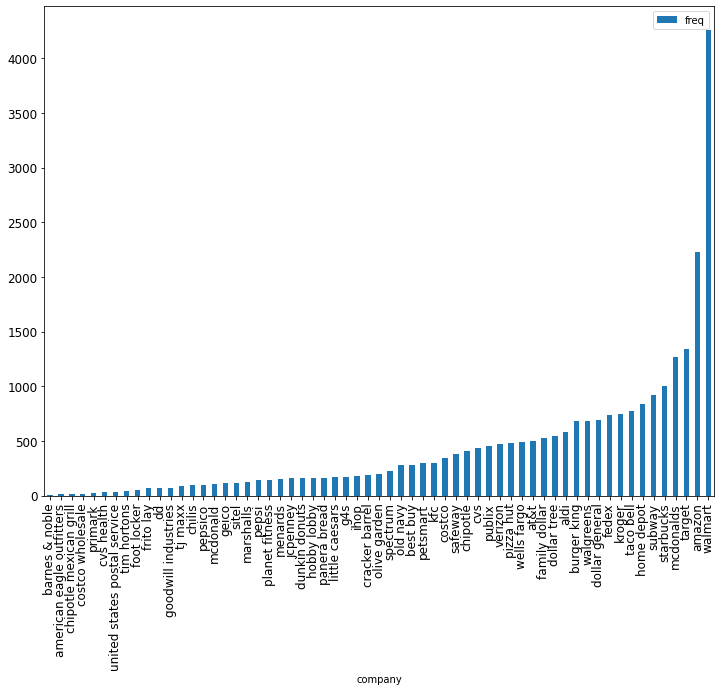

In [89]:
_company_freqs_df = pd.DataFrame(_company_freqs[:-1], columns=['company', 'freq'])
_company_freqs_df.plot.bar(x='company', y='freq', rot=90, fontsize=12, figsize=(12,9))

In [56]:
ee_emb_df = pd.read_csv(ee_emb_path)
_emb_company_df = ee_emb_df[ee_emb_df['concept'] == 'company']
_emb_company_list = _emb_company_df['neighbor'].tolist()

ee_lm_df = pd.read_csv(ee_LM_path)
_lm_company_df = ee_lm_df[ee_lm_df['concept'] == 'company']
_lm_company_list = _lm_company_df['neighbor'].tolist()

len(_emb_company_list), len(_lm_company_list)

(8059, 8037)

In [101]:
for _e, _cnt in _company_freqs:
    print(f'{_e:24s}',
          _cnt,
          _emb_company_list.index(_e) if _e in _emb_company_list else -1,
          _lm_company_list.index(_e) if _e in _lm_company_list else -1)

barnes & noble           4 3865 150
american eagle outfitters 12 3212 1050
chipotle mexican grill   15 2000 1490
costco wholesale         19 847 705
primark                  22 1013 996
cvs health               30 1937 205
united states postal service 37 399 1793
tim hortons              47 221 448
foot locker              50 171 4058
frito lay                67 32 4141
dd                       68 83 1615
goodwill industries      69 147 323
tj maxx                  88 48 403
chilis                   94 312 1573
pepsico                  101 52 41
mcdonald                 109 249 308
geico                    112 29 67
sitel                    114 41 2410
marshalls                127 34 161
pepsi                    144 38 8
planet fitness           146 64 454
menards                  154 23 6720
jcpenney                 158 20 2679
dunkin donuts            162 42 4135
hobby lobby              164 72 1344
panera bread             165 10 1208
little caesars           170 73 461
g4s         

In [61]:
_entity = 'barnes & noble'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

In my experience , booksellers at Barnes & Noble are not the cream of the crop employees , despite the company 's pretentious attitude towards applicants .

Working hours at Barnes & Noble are not great unless you are a manager .

The best age to work at Barnes & Noble is in your early 20 's , especially while going to school .

ask each customer to make a charitable donation of a book to a Barnes & Noble designated charity -- on and on --- overall , they just want to suck as much money out of each customer as possible .

I have never work at Barnes & Noble before , I would like to work there , Because I Love the books .

It is rather simple and easy to apply online , on the Barnes & Noble website .

Barnes & Noble is a very sales - driven environment where your ability to sell memberships and upsell Café items is paramount .

I always regret I could'nt find a career with Barnes & Noble , but it was not in the cards .

They took over the Barnes & Noble contract from Control Security an

In [63]:
_entity = 'american eagle outfitters'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

It took American Eagle Outfitters less than a week to schedule my training day after getting the position .

No orientation is not paid for at American Eagle Outfitters

No you do not have to be a certain height to work at American Eagle Outfitters .

In able to work at American Eagle Outfitters , you have to be at least the age of seventeen .

Working at American Eagle Outfitters on Sunday , you get time and a half .

No , they did not drug test at American Eagle Outfitters .



In [64]:
_entity = 'chipotle mexican grill'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

I got my first interview at Chipotle Mexican Grill after I applied online .

Chipotle mexican grill is a worldwide company and we have locations in Germany , London , and Canada .

I really would not mind working at a new location for Chipotle Mexican Grill , but I would have to think twice about it .

I applied for chipotle Mexican grill they never called me

Chipotle Mexican Grill terminated me as an employee .

Chipotle Mexican Grill pays bi weekly .

  I do Hope Chipotle Mexican Grill so they can fix there management .

You must be 16 years of age in order to work a Chipotle Mexican Grill .



In [65]:
_entity = 'costco wholesale'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

The overall work environment at Costco Wholesale was very strenuous .

Costco Wholesale is a great company with great benefits .

Never work at Costco wholesale

Looking to seek Employee with Costco Wholesale

References within Costco Wholesale whom are employed already .

Yes Costco Wholesale does through and complete background checks on all prospective hires .

You have to be 18 or older to work for Costco wholesale pretty sure a HS deploma or GED was required

I was hired to work at Costco Wholesale in May of 2016 .

Hi , My Costco wholesale is the very .

Good managed company by it 's CA , we are the most interested to work with the Costco wholesale .



In [66]:
_entity = 'chilis'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

A necessary qualification of a chilis restaurant manager would be respect .

You must be 16 or older to work at chilis .

At the Chilis I work at you can have dark colors nothing bright

They will usually train you or start you off ad a host then move you up from there depending on what your chilis does .

Chilis pays 2.13 .

No , because the schedule would be confusing and if you are already employed at a chilis you can only transfer to another one .

Chef 's pants hat and shirt made by chilis

Do i qualify to work with chilis

What is Chilis music policy

I have never felt more unhappy in a work place than I did working at this Chilis .

.unfortunately had to transfer to the chili 's in galveston tx ... i had the notion that all chilis would be like my home store .. boy was i ever wrong .. the store was ran so poorly that i caught myself saying , " i ca nt wait to get off so i can leave this place" .. i never felt so unappreciated or tooken advantage of by their management staff ... 

In [85]:
_entity = 'retail'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

STANDARD INTERVIEW QUESTIONS FOR RETAIL POSITIONS .

Why I was interested in retail ?

Very friendly , they just want to get to know you and see how much experience you have with retail .

I am sure there is always a need for   employees and quite honestly you can find a positon that fits you because the is a huge volume   of everything in the clothing , retail , cashier gift cards and have ahuge parking lot close to condominuim and several offices .

Yes , they 're always looking for new employees to help out during the holidays and its a great place to start work in retail .

this is retail store so this is ok

This only applies to the retail side of Marshall 's .

It is retail so my schedule is different every week .

I did n't mind it at first for a part time job to have me do something while I was in community college , but now that I left I 'd say that this is a great first job if you 're wanting to experience what retail is like .

This was a training position that focused train

  Then I worked my 3rd and 4th days on a clearance sale .... with a new key holder .. who had zero retail or managerial experience .

Dollar General is just like every other retail employer .

Management is just as sketchy as at any other retail company .


 You could tell the store manager had no experience in retail .

This is a warning for anyone enrty level or advanced in retail DO NOT WORK FOR DOLLAR GENERAL ! ! ! !

Bi weekly , maybe a year , if you like retail you 'll fit in just fine .

I have lots of retail and customer service experience and management experience

I have a retail fraud   misdemeanor   it was 8 years ago do u think dollar general will hold that against me

This is retail not warehouse .

Retail experience

Plus it does n't hurt if you are young and / or a sketchy character .. a retail employers delight .

You will not be hired for a retail position if you have a theft charge .

This goes for most if not all retail jobs .

It 's a typical retail job .

Theft an

  I found one of the MOST DIFFICULT parts of my job was being an INTERIOR DESIGNER IN A RETAIL ENVIRONMENTAL .



 The store manager sets the culture and our store 's manager came from a VP Operations position ( when his layer of mgmt was eliminated ) , with apparently little front line retail experience , resulting in poor accountability for co - workers .

if you 've worked in retail , you 'll make more than the base pay . )

Because it is retail and not many people can maneuver their lives to fit their job .

If I remember correctly , no experience was required to work there , but it definitely would n't hurt to have a little retail and customer service experience if possible .

I have a retail 8 yrs ago will it show up om back ground



 
  Though my experience has been in construction , retail , automotive , 
 and gas sales , in operating my own businesses I have acquired the ability 
 to adjust and conform to all and any business environments .

It Is Retail .

Yes , this is the 

In [111]:
_entity = 'ys'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(d['company'], ':', _sent)
        print()

The Home Depot : Yes , and ys

Family Dollar : Ys hard for you have

Barnes & Noble : Hello my name is julian and i currently live in carbondale and i was just going to say i would more likely to work with you guys if i ever decide to see ys soon if possible .



### benefits

In [90]:
_benefits_freqs = []
for _e in all_benchmark_instances['benefits']:
    try:
        _freq = embed_num_dict[_e]
        _benefits_freqs.append((_e, _freq))
    except:
        continue
_benefits_freqs.sort(key=lambda p: p[-1])

In [91]:
_benefits_freqs

[('health benefits', 4),
 ('tuition assistance', 20),
 ('monthly bonus', 23),
 ('retirement plan', 32),
 ('paid vacations', 36),
 ('prescription drugs', 46),
 ('401k plan', 50),
 ('pension', 51),
 ('401 k', 71),
 ('sick leave', 133),
 ('life insurance', 183),
 ('health care', 222),
 ('healthcare', 233),
 ('sick days', 248),
 ('401k', 640),
 ('health insurance', 782),
 ('health', 1294)]

In [94]:
_benefits_freqs_df = pd.DataFrame(_benefits_freqs, columns=['benefits', 'freq'])

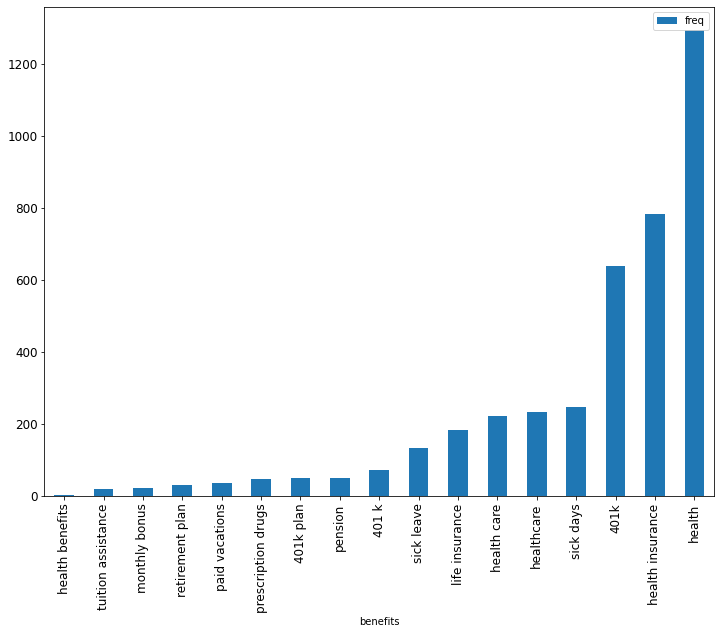

In [95]:
_benefits_freqs_df.plot.bar(x='benefits', y='freq', rot=90, fontsize=12, figsize=(12,9))

In [97]:
ee_emb_df = pd.read_csv(ee_emb_path)
_emb_benefits_df = ee_emb_df[ee_emb_df['concept'] == 'benefits']
_emb_benefits_list = _emb_benefits_df['neighbor'].tolist()

ee_lm_df = pd.read_csv(ee_LM_path)
_lm_benefits_df = ee_lm_df[ee_lm_df['concept'] == 'benefits']
_lm_benefits_list = _lm_benefits_df['neighbor'].tolist()

len(_emb_benefits_list), len(_lm_benefits_list)

(8058, 8036)

In [99]:
for _e, _cnt in _benefits_freqs:
    print(f'{_e:24s}',
          _cnt,
          _emb_benefits_list.index(_e) if _e in _emb_benefits_list else -1,
          _lm_benefits_list.index(_e) if _e in _lm_benefits_list else -1)

health benefits          4 3255 13
tuition assistance       20 944 125
monthly bonus            23 809 142
retirement plan          32 73 124
paid vacations           36 64 70
prescription drugs       46 570 322
401k plan                50 326 672
pension                  51 62 1
401 k                    71 302 3307
sick leave               133 -1 -1
life insurance           183 7 16
health care              222 1 22
healthcare               233 0 101
sick days                248 9 494
401k                     640 -1 -1
health insurance         782 -1 -1
health                   1294 6 9


In [102]:
_entity = 'tuition assistance'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

The tuition assistance is TRASH ! !

No amazon do not have tuition assistance for part time employees .

Tuition assistance is provided based on the program and school you choose , and is available for consideration after one consecutive year of work with the company .

As soon as you get through your trial period you can apply for the tuition assistance .

They offer medical plans , tuition assistance , sick days(in small increments based on time worked ) , paid time off(again in small increments . ) ,

After one year of working for Chipotle , students are offered tuition assistance if they are not offered federal financial assistance .

Yes you need to work there for a year to sign up for tuition assistance .

Lots of training opportunities and Tuition Assistance .

Yes $ 6000 of tuition assistance .

  Tuition assistance is available the very first day you start .

There is also , tuition assistance program for promotion within the company .

No , however , they do offer tuition ass

In [103]:
_entity = '401k plan'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

401k Plan medical and dental paid vacation raise after 90 days

There is a 401k plan , but I ca n't remember if it 's 3 months or 1 year after being with them .

They paid me once a week which was great , they have a good 401k plan and good health benefits

The Starbucks was inside of Kroger so you receive Kroger benefits as well such as 401k plan

The company benefits are full benefits , 401k plan , PTO , Bonuses , Company Perks

Heath care 
 dental 
 vision 
 awesome 401k plan

Standard health benefits , school reimbursement , 401k plan

1 year in order to get tuition for school and i believe the 401k plan is instant .

They do not have a 401k plan

I do not have a 401k plan

No I do not have a 401k plan .

No i do not have 401k plan

No I do n't have a 401k plan but I do know it is a option .

Yes wlgreens does offer you a 401k plan .

401k plan after 6 months or 1 year .

After a year you can start a 401k plan , get health and dental , along with buying stocks .

Wal - mart 's bene

In [137]:
_entity = 'freelancer'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(d['company'], ':', _sent)
        print()

Amazon.com : Yes , as a freelancer

Macy's : With Macys as a freelancer the pay is weekly .

Macy's : It 's different for every person , whether you work for the counter or are a freelancer

G4S : Hi 
 I am freelancer Sohan 
 Place copy types



## Relational context analysis

In [130]:
def get_masked_contexts_for_entities_with_rels(entities,
                                               input_corpus,
                                               with_entities):
    """Return a (list of) sentence(s) with entity replaced with MASK."""
    """YS: input should be sentences_with_company.json"""
    
    ent_freq = {ent : 0 for ent in entities}
    ent_context = {ent : [] for ent in entities}
    
#     with open(input_file, "r") as fin:
#         lines = fin.readlines()
#     for line in tqdm(lines, total=len(lines), desc="loading corpus"):
#         json_dict = json.loads(line)
    for json_dict in input_corpus:
        sent = ' ' + ' '.join(json_dict['tokens']).lower() + ' '
        #entities = [match.group(1) for match in re.finditer(pat, line)]

        if not any([f' {_e} ' in sent for _e in with_entities]):
            # not including with_entities
            continue

        for entity in entities:
            pat = f' {entity} '
            if pat not in sent:
                continue

            context = sent.replace(pat, ' [MASK] ').strip()
            c = context.split('[MASK]')
            if len(c) != 2:  # sanity to not have too many repeating phrases in the context
                continue

            # ignore too short contexts
            if len(context) < 15:
                continue

            # print(entity)
            # print(context)

            _freq = ent_freq.get(entity, 0)
            ent_freq[entity] = _freq + 1

            context_lst = ent_context.get(entity, [])
            context_lst.append(context)
            ent_context[entity] = context_lst

    dedup_context = {}
    for e, v in ent_context.items():
        dedup_context[e] = list(set(v))
    return ent_freq, dedup_context


In [131]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [133]:
get_masked_contexts_for_entities_with_rels(entities=["home depot", "subway", "starbucks", "mcdonalds"],
    input_corpus=sent_dicts,
    with_entities=["health insurance", "flexible schedule", "401k", "paid vacation", "sick leave", "vision insurance"])

({'home depot': 1, 'subway': 0, 'starbucks': 4, 'mcdonalds': 4},
 {'home depot': ['no , since obama care [MASK] dropped health insurance for part time employees'],
  'subway': [],
  'starbucks': ['the [MASK] was inside of kroger so you receive kroger benefits as well such as 401k plan',
   'you have to work a full 32 + hours a week to get health insurance in [MASK] .',
   'yes , 401k , and 30 % off items for [MASK] .',
   'yes , all [MASK] partners averaging 20 hours or more per work week are eligible for medical benefits , 401k , and stock options .'],
  'mcdonalds': ['the reason for leaving [MASK] was due to the flexible schedule',
   'i was offered 401k with [MASK] .',
   'do [MASK] pay you on sick leave to',
   'no managers at this [MASK] receive health insurance of any kind .']})

### All companies, all benefits

In [134]:
concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_instances_dict = dict(zip(concepts_df['alignedCategoryName'], concepts_df['seedInstances']))

_collected_company = list(all_benchmark_instances['company'] | set(seed_instances_dict['company']))
_collected_benefits = list(all_benchmark_instances['benefits'] | set(seed_instances_dict['benefits']))

In [136]:
_company_cnt, _company_contexts = get_masked_contexts_for_entities_with_rels(
    entities=_collected_company,
    input_corpus=sent_dicts,
    with_entities=_collected_benefits
)

In [137]:
_company_cnt_list = sorted(_company_cnt.items(), key=lambda p: p[1])
_company_cnt_list

[('frito-lay', 0),
 ('spectrum', 0),
 ('allied universal security services, systems and solutions', 0),
 ('t-mobile', 0),
 ('marriott international, inc.', 0),
 ("dick's sporting goods", 0),
 ('alorica', 0),
 ("macy's", 0),
 ("kohl's", 0),
 ('ross dress for less', 0),
 ('microsoft', 0),
 ('geico', 0),
 ('olive garden', 0),
 ("mcdonald's", 0),
 ('electric', 0),
 ('ulta', 0),
 ("chili's", 0),
 ('concentrix', 0),
 ("dunkin' donuts", 0),
 ("lowe's", 0),
 ("domino's", 0),
 ('kroger stores', 0),
 ('sonic drive-in', 0),
 ('subways', 0),
 ('costco wholesale', 0),
 ('chipotle mexican grill', 0),
 ('chick-fil-a', 0),
 ("victoria's secret", 0),
 ('goodwill industries', 0),
 ('quiktrip', 0),
 ('barnes & noble', 0),
 ('american eagle outfitters', 0),
 ("the wendy's company", 0),
 ('teleperformance', 0),
 ('united states postal service', 0),
 ('dunkin donuts', 0),
 ('tim hortons', 0),
 ('frito lay', 0),
 ('t.j. maxx', 0),
 ("sam's club", 0),
 ("applebee's", 0),
 ('burlington stores', 0),
 ('chilis',

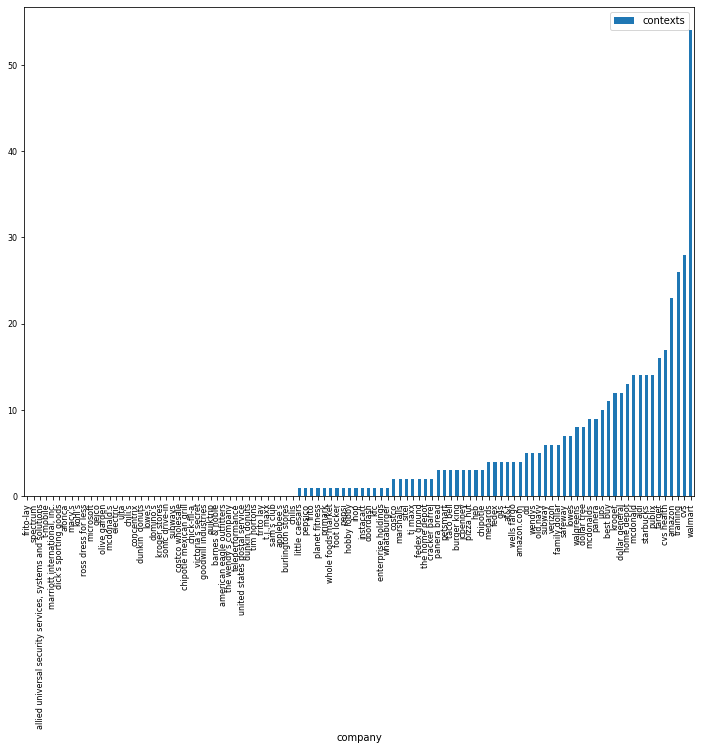

In [138]:
_company_cnt_df = pd.DataFrame(_company_cnt_list, columns=['company', 'contexts'])
_company_cnt_df.plot.bar(x='company', y='contexts', rot=90, fontsize=8, figsize=(12,9))

### Single companies, all concepts, embedding t-SNE

In [127]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

mask_token_id = bert_tokenizer.mask_token_id

In [139]:
_company = 'walmart'

cc_embeddings = dict()
for _cc, _seeds in seed_instances_dict.items():
    if _cc == 'company':
        continue
    
    _collected_cc_entities = list(all_benchmark_instances[_cc] | set(_seeds))
    print(_cc, _collected_cc_entities)
    
    # Get masked contexts
    _, _contexts = get_masked_contexts_for_entities_with_rels(
        entities=[_company],
        input_corpus=sent_dicts,
        with_entities=_collected_cc_entities
    )
    _contexts = _contexts[_company]
    if len(_contexts) == 0:
        continue
    
    # Compute context embedding 
    en_context_lst = _contexts
    chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
    # print(entity)
    # print(len(en_context_lst))
    _all_context_embeddings = []
    for chunk in chunks:
        _encoded_input = bert_tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
        _mask = _encoded_input['input_ids'] != mask_token_id
        with torch.no_grad():
            _encoded_input = ensure_tensor_on_device(device, **_encoded_input)
            _model_output = bert_model(**_encoded_input)  # Compute token embeddings
        _context_embeddings = mean_pooling(_model_output, _mask)  # mean pooling
        _all_context_embeddings.append(_context_embeddings)

    assert len(_all_context_embeddings) > 0

    _entity_embedding = torch.mean(torch.cat(_all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
    cc_embeddings[_cc] = _entity_embedding
    

dress_code ['wear fake nails', 'fake nails', 'jewelry', 'tattoos', 'shirt', 'brown pants', 'color hair', 'pants', 'black slacks', 'dress pants', 'lab coats', 'black jeans', 'shirts', 'facial piercings', 'uniform', 'face tattoos', 'strict dress code', 'polo shirts', 'hairnets', 'hair net', 'mustaches', 'natural colors', 'red shirts', 'resistant shoes', 'hair color', 'shoes', 'wear jeans', 'wear shorts', 'casual dress code', 'casual', 'hat', 'non slip shoes', 'unnatural hair color', 'piercings', 'unnatural hair colors', 'professional', 'unnatural colored hair', 'hats', 'nose rings', 'colorful hair', 'skirts', 'scrubs', 'dress shirts', 'attire', 'jeans', 'uniforms', 'uniform policy', 'natural colored hair', 'blue collar', 'business casual', 'uniform shirts', 'facial hair', 'ponytail', 'black pants', 'shorts', 'hair colors']
job_position ['sales associate', 'barista', 'delivery driver', 'servers', 'shift leader', 'cashier', 'store manager', 'dishwasher', 'package handler', 'truck drivers',

In [140]:
len(cc_embeddings)

13

In [144]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
embeddings_df = load_embeddings(bert_emb_path, 768)
_company_embedding_all = embeddings_df[embeddings_df['entity'] == _company]['embedding'].item()
cc_embeddings['all'] = _company_embedding_all

In [150]:
tsne = TSNE()
_concepts, _raw_embs = zip(*cc_embeddings.items())
_tsne_embs = tsne.fit_transform(_raw_embs).tolist()

In [151]:
list(zip(_concepts, _tsne_embs))

[('dress_code', [-145.94862365722656, 57.3772087097168]),
 ('job_position', [-39.565086364746094, -108.43943786621094]),
 ('pay_schedule', [152.2614288330078, -63.55064010620117]),
 ('benefits', [-43.94044494628906, 73.60016632080078]),
 ('compensation', [2.41005277633667, -4.917022228240967]),
 ('payment_option', [90.35870361328125, 19.138399124145508]),
 ('background_screening', [192.3670196533203, 35.36241912841797]),
 ('person', [57.58891296386719, -88.47061920166016]),
 ('hire_prerequisite', [-11.17064094543457, 181.2088165283203]),
 ('shifts', [-95.37789154052734, -26.44676971435547]),
 ('schedule', [85.98265838623047, 201.17864990234375]),
 ('employee_type', [-105.84320068359375, 156.29014587402344]),
 ('onboarding_steps', [44.008026123046875, 97.65530395507812]),
 ('all', [141.7953643798828, 119.18583679199219])]

In [ ]:
_tsne_x, _tsne_y = list(zip(*_tsne_embs))

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

for _cc, _emb in list(zip(_concepts, _tsne_embs)):
    ax.text(x=_emb[0]/200, y=_emb[1]/200, s=_cc, ha='center')

# ax.legend()
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
fig.show()

## EE labels preprocessing

### Combine emb & LM files (obsolete)

In [75]:
raw_EE_emb_labeling_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-emb-labels.csv')
raw_EE_LM_labeling_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-lm-labels.csv')

out_EE_label_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels.csv')

In [76]:
_raw_emb = pd.read_csv(raw_EE_emb_labeling_file)
_raw_lm = pd.read_csv(raw_EE_LM_labeling_file)

_raw_emb_gold = _raw_emb[_raw_emb['Majority'] == 1].to_dict('records')
_raw_lm_gold = _raw_lm[_raw_lm['Majority'] == 1].to_dict('records')
len(_raw_emb_gold), len(_raw_lm_gold)

(623, 676)

In [77]:
gold_labels_dict = dict()
for d in _raw_emb_gold + _raw_lm_gold:
    _cc = d['concept']
    _e = d['neighbor']
    gold_labels_dict[_cc] = gold_labels_dict.get(_cc, []) + [_e]

for _cc, _e_list in gold_labels_dict.items():
    gold_labels_dict[_cc] = list(set(_e_list))

In [78]:
for _cc, _e_list in gold_labels_dict.items():
    print(f'{_cc}: {len(_e_list)}')

company: 119
dress_code: 261
job_position: 127
pay_schedule: 37
benefits: 91
compensation: 42
payment_option: 30
background_screening: 84
person: 42
hire_prerequisite: 109
shifts: 70
schedule: 62
employee_type: 25
onboarding_steps: 20


In [79]:
gold_labels_list = []
for _cc, _e_list in gold_labels_dict.items():
    for _e in _e_list:
        gold_labels_list.append((_cc, _e))
pd.DataFrame(gold_labels_list, columns=['concept', 'neighbor']).to_csv(out_EE_label_file, index=False)

### Extract labeled entities

In [233]:
in_EE_label_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-increment-labels-2.csv')
out_EE_label_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels-2.csv')

In [234]:
in_ee_df = pd.read_csv(in_EE_label_file)

gold_labels_dict = dict()
for d in in_ee_df.to_dict('records'):
    if d['Majority'] != 1:
        continue
    _cc = d['concept']
    _e = d['neighbor']
    gold_labels_dict[_cc] = gold_labels_dict.get(_cc, []) + [_e]


In [235]:
for _cc, _e_list in gold_labels_dict.items():
    print(f'{_cc}: {len(_e_list)}')

company: 155
dress_code: 268
job_position: 152
pay_schedule: 37
benefits: 116
compensation: 47
payment_option: 30
background_screening: 104
person: 67
hire_prerequisite: 137
shifts: 89
schedule: 69
employee_type: 30
onboarding_steps: 30


In [236]:
gold_labels_list = []
for _cc, _e_list in gold_labels_dict.items():
    for _e in _e_list:
        gold_labels_list.append((_cc, _e))
pd.DataFrame(gold_labels_list, columns=['concept', 'neighbor']).to_csv(out_EE_label_file, index=False)

### Increment label file

In [103]:
ee_incre_label_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-increment-labels-2.csv')
ee_pred_paths = [
    os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_roberta_k=None.csv'),
    os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_roberta_k=None.csv'),
    os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_roberta_k=None.csv'),
    os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_roberta_contr_k=None.csv'),
]
# ee_pred_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn-aux-k=None.csv')

In [104]:
# Self-check and dedup current label file 

ee_label_df = pd.read_csv(ee_incre_label_path)
ee_label_dict = dict()  # Dict[(cc, e), maj]
for _d in ee_label_df.to_dict('record'):
    _key = (_d['concept'], _d['neighbor'])
    _label = ee_label_dict.get(_key, None)
    if _label is None:
        ee_label_dict[_key] = _d['Majority']
    elif _label == 'ERR':
        pass
    else:
        if _label != _d['Majority']:
            print(f"Contradict: {_key}")
            ee_label_dict[_key] = 'ERR'

In [105]:
len(ee_label_dict)

3435

In [106]:
_concepts = ee_label_df['concept'].drop_duplicates(keep='first').tolist()
_concepts_order_dict = dict([(_concepts[i], i) for i in range(len(_concepts))])
_concepts_order_dict

{'company': 0,
 'dress_code': 1,
 'job_position': 2,
 'pay_schedule': 3,
 'benefits': 4,
 'compensation': 5,
 'payment_option': 6,
 'background_screening': 7,
 'person': 8,
 'hire_prerequisite': 9,
 'shifts': 10,
 'schedule': 11,
 'employee_type': 12,
 'onboarding_steps': 13}

In [107]:
K = 100

for ee_pred_path in ee_pred_paths:
    ee_new_df = pd.read_csv(ee_pred_path)

    for _cc in _concepts:
        _new_ents = ee_new_df[ee_new_df['concept'] == _cc]['neighbor'].tolist()[:K]
        for _e in _new_ents:
            _key = (_cc, _e)
            if _key in ee_label_dict:
                continue
            ee_label_dict[_key] = None

len(ee_label_dict)

5620

In [109]:
_out_records = []
_added_keys = set()

# remove existing errors 
for _d in ee_label_df.to_dict('record'):
    _cc = _d['concept']
    _e = _d['neighbor']
    if (_cc, _e) in _added_keys:
        continue
        
    if ee_label_dict[(_cc, _e)] == 'ERR':
        _d['label-Nikita'] = _d['label-Sajjadur'] = _d['label-Yutong'] = \
        _d['Disagree'] = _d['Majority'] = np.nan
    _out_records.append(_d)   
    _added_keys.add((_cc, _e))

for (_cc, _e), _label in ee_label_dict.items():
    if (_cc, _e) in _added_keys:
        continue
        
    _out_records.append({
        'concept': _cc,
        'neighbor': _e,
        'label-Nikita': np.nan,
        'label-Sajjadur': np.nan,
        'label-Yutong': np.nan,
        'Disagree': np.nan,
        'Majority': np.nan
    })
    _added_keys.add((_cc, _e))

_out_records.sort(key=lambda d : (np.isnan(d['Majority']), _concepts_order_dict[d['concept']]))
_out_records[:3], _out_records[-3:]

([{'concept': 'company',
   'neighbor': 'wal mart',
   'label-Nikita': 1,
   'label-Sajjadur': 1.0,
   'label-Yutong': 1,
   'Disagree': 0,
   'Majority': 1},
  {'concept': 'company',
   'neighbor': 'walmart',
   'label-Nikita': 1,
   'label-Sajjadur': 1.0,
   'label-Yutong': 1,
   'Disagree': 0,
   'Majority': 1},
  {'concept': 'company',
   'neighbor': 'costco',
   'label-Nikita': 1,
   'label-Sajjadur': 1.0,
   'label-Yutong': 1,
   'Disagree': 0,
   'Majority': 1}],
 [{'concept': 'onboarding_steps',
   'neighbor': 'changeup',
   'label-Nikita': nan,
   'label-Sajjadur': nan,
   'label-Yutong': nan,
   'Disagree': nan,
   'Majority': nan},
  {'concept': 'onboarding_steps',
   'neighbor': 'personal issues',
   'label-Nikita': nan,
   'label-Sajjadur': nan,
   'label-Yutong': nan,
   'Disagree': nan,
   'Majority': nan},
  {'concept': 'onboarding_steps',
   'neighbor': 'basic information',
   'label-Nikita': nan,
   'label-Sajjadur': nan,
   'label-Yutong': nan,
   'Disagree': nan,
  

In [110]:
# ee_incre_new_path: the new unlabeled file 
ee_incre_new_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-increment-labels-NEW3.csv')
pd.DataFrame(_out_records).to_csv(ee_incre_new_path, index=None)

## Entity expansion evaluation
Now using benchmark entities, mean reciprocal rank

In [96]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_knn_roberta_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_concept_knn_roberta_k=None_eval.csv \
-rank sim \
-rev

--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   8058    150    0.3733  0.3733  1.0000  0.1333  0.5200  0.3467 
dress_code                8056    261    0.2184  0.2184  0.8000  0.0613  0.3500  0.1341 
job_position              8056    145    0.1310  0.1310  0.4500  0.0621  0.1800  0.1241 
pay_schedule              8059     34    0.0882  0.0882  0.1500  0.0882  0.0500  0.1471 
benefits                  8057    110    0.2182  0.2182  0.6500  0.1182  0.2400  0.2182 
compensation              8059     43    0.1163  0.1163  0.1000  0.0465  0.0800  0.1860 
payment_option            8060     27    0.1481  0.1481  0.2000  0.1481  0.0600  0.2222 
background_screening      8060    102    0.2157  0.2157  0.3500  0.0686  0.2200  0.2157 
person                    8054     58    0.1034  0.1034  0.0500  0.0172  0.0700  0.1207 
hire_prerequisite         8058    133    0.1278  0.1278  0.3500  0.0526  0.1500  0.1128 
shift

In [98]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_roberta_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_roberta_k=None_eval.csv \
-rank sim+margin \
-rev

--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   1217    150    0.3800  0.3800  1.0000  0.1333  0.5100  0.3400 
dress_code                241     261    0.7593  0.7011  1.0000  0.0766  0.8300  0.3180 
job_position              633     145    0.2138  0.2138  0.4500  0.0621  0.2600  0.1793 
pay_schedule               13      34    0.1538  0.0588  0.1538  0.0588  0.1538  0.0588 
benefits                  159     110    0.2636  0.2636  0.8000  0.1455  0.2700  0.2455 
compensation               40      43    0.1250  0.1163  0.1500  0.0698  0.1250  0.1163 
payment_option             80      27    0.3333  0.3333  0.3500  0.2593  0.1250  0.3704 
background_screening      1698    102    0.2157  0.2157  0.4500  0.0882  0.2200  0.2157 
person                    101      58    0.1724  0.1724  0.2000  0.0690  0.1400  0.2414 
hire_prerequisite         208     133    0.2105  0.2105  0.5000  0.0752  0.1900  0.1429 
shift

In [ ]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_acontr_knn_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_concept_acontr_knn_k=None_eval.csv \
-rank sim+margin \
-rev

In [99]:
# Use script
# Using 'aux' doesn't matter for non contrastive methods

!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_roberta_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_LM_roberta_k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   7926    150    0.1200  0.1200  0.2000  0.0267  0.1700  0.1133 
dress_code                7924    261    0.4789  0.4789  0.7000  0.0536  0.7200  0.2759 
job_position              7924    145    0.5448  0.5448  0.8000  0.1103  0.6600  0.4552 
pay_schedule              7927     34    0.5000  0.5000  0.7500  0.4412  0.2000  0.5882 
benefits                  7925    110    0.5273  0.5273  0.9000  0.1636  0.5800  0.5273 
compensation              7927     43    0.3953  0.3953  0.4500  0.2093  0.3000  0.6977 
payment_option            7928     27    0.4815  0.4815  0.4000  0.2963  0.2200  0.8148 
background_screening      7928    102    0.5196  0.5196  0.8000  0.1569  0.5200  0.5098 
person                    7922     58    0.3621  0.3621  0.7000  0.2414  0.2400  0.4138 
hire_prerequisite         7926    133    0.4135  0.4135  0.6500  0.0977  0.5100  0.3835 
shift

In [100]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_roberta_contr_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_LM_roberta_contr_k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   3712    150    0.1333  0.1333  0.3500  0.0467  0.1700  0.1133 
dress_code                419     261    0.5977  0.5977  0.7500  0.0575  0.8100  0.3103 
job_position              376     145    0.5931  0.5931  0.8500  0.1172  0.6700  0.4621 
pay_schedule              167      34    0.3235  0.3235  0.5000  0.2941  0.1200  0.3529 
benefits                  148     110    0.4636  0.4636  0.9000  0.1636  0.5100  0.4636 
compensation              159      43    0.4419  0.4419  0.5000  0.2326  0.2900  0.6744 
payment_option            162      27    0.4815  0.4815  0.4500  0.3333  0.1900  0.7037 
background_screening      226     102    0.5588  0.5588  0.7500  0.1471  0.5600  0.5490 
person                    435      58    0.3793  0.3793  0.8000  0.2759  0.2800  0.4828 
hire_prerequisite         879     133    0.3534  0.3534  0.6000  0.0902  0.4200  0.3158 
shift

In [ ]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_bert_acontr_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_acontr_k=None_eval.csv


In [124]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_mrr_combine_roberta_k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_mrr_combine_roberta_k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   7942    150    0.3800  0.3800  0.7000  0.0933  0.4400  0.2933 
dress_code                7924    261    0.7241  0.7241  0.8000  0.0613  0.8300  0.3180 
job_position              7924    145    0.5034  0.5034  0.7000  0.0966  0.6100  0.4207 
pay_schedule              7927     34    0.4706  0.4706  0.5500  0.3235  0.2000  0.5882 
benefits                  7926    110    0.5000  0.5000  1.0000  0.1818  0.5300  0.4818 
compensation              7927     43    0.3256  0.3256  0.3500  0.1628  0.2700  0.6279 
payment_option            7928     27    0.3333  0.3333  0.3500  0.2593  0.2100  0.7778 
background_screening      7956    102    0.4314  0.4314  0.6500  0.1275  0.4300  0.4216 
person                    7922     58    0.4310  0.4310  0.6000  0.2069  0.2700  0.4655 
hire_prerequisite         7926    133    0.3910  0.3910  0.6500  0.0977  0.3700  0.2782 
shift

In [ ]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_mrr_combine_2-emb_contr+lm_contr-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_mrr_combine_2-k=None_eval.csv


In [283]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn-aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn-aux-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   175     150    0.4733  0.4733  1.0000  0.1333  0.6900  0.4600 
dress_code                 75     261    0.8667  0.2490  1.0000  0.0766  0.8667  0.2490 
job_position               62     145    0.6452  0.2759  0.9000  0.1241  0.6452  0.2759 
pay_schedule               15      34    0.2000  0.0882  0.2000  0.0882  0.2000  0.0882 
benefits                   71     110    0.5211  0.3364  0.8500  0.1545  0.5211  0.3364 
compensation               73      43    0.3488  0.3488  0.4500  0.2093  0.2740  0.4651 
payment_option            110      27    0.5185  0.5185  0.6500  0.4815  0.1600  0.5926 
background_screening      576     102    0.4118  0.4118  0.6500  0.1275  0.4100  0.4020 
person                    168      58    0.3103  0.3103  0.4000  0.1379  0.2800  0.4828 
hire_prerequisite         128     133    0.3359  0.3233  0.8500  0.1278  0.4100  0.3083 
shift

In [372]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_acontr_knn-aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_concept_acontr_knn-aux-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   8059    150    0.4467  0.4467  1.0000  0.1333  0.6300  0.4200 
dress_code                8057    261    0.3985  0.3985  0.9500  0.0728  0.7200  0.2759 
job_position              8057    145    0.2690  0.2690  0.7000  0.0966  0.3400  0.2345 
pay_schedule              8060     34    0.1471  0.1471  0.2500  0.1471  0.0900  0.2647 
benefits                  8058    110    0.2364  0.2364  0.7000  0.1273  0.2500  0.2273 
compensation              8060     43    0.2791  0.2791  0.3500  0.1628  0.1900  0.4419 
payment_option            8061     27    0.5556  0.5556  0.6500  0.4815  0.1600  0.5926 
background_screening      8061    102    0.3725  0.3725  0.6500  0.1275  0.3800  0.3725 
person                    8055     58    0.1724  0.1724  0.4000  0.1379  0.1200  0.2069 
hire_prerequisite         8059    133    0.2180  0.2180  0.7500  0.1128  0.2600  0.1955 
shift

In [284]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_bert_contr-aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_contr-aux-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   987     150    0.5067  0.5067  1.0000  0.1333  0.7300  0.4867 
dress_code                331     261    0.5900  0.5900  1.0000  0.0766  0.9400  0.3602 
job_position              206     145    0.6207  0.6207  1.0000  0.1379  0.8700  0.6000 
pay_schedule               20      34    0.6000  0.3529  0.6000  0.3529  0.6000  0.3529 
benefits                  229     110    0.7182  0.7182  1.0000  0.1818  0.7800  0.7091 
compensation              175      43    0.5814  0.5814  0.7000  0.3256  0.3400  0.7907 
payment_option            178      27    0.5185  0.5185  0.5500  0.4074  0.1800  0.6667 
background_screening      259     102    0.5980  0.5980  0.7500  0.1471  0.6100  0.5980 
person                    215      58    0.4310  0.4310  0.7000  0.2414  0.3100  0.5345 
hire_prerequisite         441     133    0.4436  0.4436  0.5500  0.0827  0.5400  0.4060 
shift

In [374]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_bert_acontr-aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_acontr-aux-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   8012    150    0.5267  0.5267  1.0000  0.1333  0.7400  0.4933 
dress_code                8010    261    0.5939  0.5939  0.9500  0.0728  0.9100  0.3487 
job_position              8010    145    0.7034  0.7034  0.9000  0.1241  0.8900  0.6138 
pay_schedule              8013     34    0.6176  0.6176  0.8500  0.5000  0.2100  0.6176 
benefits                  8011    110    0.7273  0.7273  1.0000  0.1818  0.7600  0.6909 
compensation              8013     43    0.5814  0.5814  0.7000  0.3256  0.3400  0.7907 
payment_option            8014     27    0.4815  0.4815  0.5000  0.3704  0.1800  0.6667 
background_screening      8014    102    0.6078  0.6078  0.7500  0.1471  0.6200  0.6078 
person                    8008     58    0.4483  0.4483  0.7000  0.2414  0.3500  0.6034 
hire_prerequisite         8012    133    0.4436  0.4436  0.6000  0.0902  0.5300  0.3985 
shift

In [387]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_mrr_combine_3-emb_contr_aux+lm_contr_aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_mrr_combine_3-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   1111    150    0.8067  0.8067  1.0000  0.1333  0.9100  0.6067 
dress_code                358     261    0.6475  0.6475  1.0000  0.0766  0.9400  0.3602 
job_position              247     145    0.7517  0.7517  1.0000  0.1379  0.8400  0.5793 
pay_schedule               34      34    0.4412  0.4412  0.7000  0.4118  0.4412  0.4412 
benefits                  273     110    0.6545  0.6545  0.9500  0.1727  0.6800  0.6182 
compensation              222      43    0.5581  0.5581  0.6500  0.3023  0.3500  0.8140 
payment_option            269      27    0.5926  0.5926  0.6000  0.4444  0.2600  0.9630 
background_screening      772     102    0.5784  0.5784  0.8500  0.1667  0.5900  0.5784 
person                    352      58    0.4310  0.4310  0.7500  0.2586  0.3600  0.6207 
hire_prerequisite         548     133    0.5714  0.5714  0.7000  0.1053  0.5700  0.4286 
shift

In [395]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_mrr_combine_4-emb_acontr_aux+lm_acontr_aux-k=None.csv \
-o $base_dir/data/$data_ac/intermediate/ee_mrr_combine_4-k=None_eval.csv


--- Summary ---
Concept                  Max K   Gold K   P@K     R@K     P@20    R@20   P@100   R@100  
company                   8106    150    0.7667  0.7667  1.0000  0.1333  0.9000  0.6000 
dress_code                8104    261    0.6667  0.6667  0.9500  0.0728  0.8800  0.3372 
job_position              8104    145    0.6483  0.6483  0.8000  0.1103  0.7500  0.5172 
pay_schedule              8107     34    0.5882  0.5882  0.7000  0.4118  0.2300  0.6765 
benefits                  8105    110    0.5636  0.5636  0.9500  0.1727  0.5900  0.5364 
compensation              8107     43    0.5116  0.5116  0.5500  0.2558  0.3600  0.8372 
payment_option            8108     27    0.5556  0.5556  0.6500  0.4815  0.2400  0.8889 
background_screening      8108    102    0.5784  0.5784  0.8500  0.1667  0.5900  0.5784 
person                    8102     58    0.3966  0.3966  0.7000  0.2414  0.2900  0.5000 
hire_prerequisite         8106    133    0.4511  0.4511  0.7000  0.1053  0.4500  0.3383 
shift

In [270]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/kv_entities-aux-EE=mrr_combine-K=20-RE=Ct+KV=0.9.csv


--- Summary ---
Concept                  Max K    MRR     P@20    R@20   P@100   R@100  
company                    12    0.0207  1.0000  0.0800  1.0000  0.0800 
dress_code                 10    0.0112  1.0000  0.0383  1.0000  0.0383 
job_position               7     0.0179  1.0000  0.0483  1.0000  0.0483 
pay_schedule               9     0.0397  0.5556  0.1471  0.5556  0.1471 
benefits                   13    0.0289  1.0000  0.1182  1.0000  0.1182 
compensation               13    0.0495  0.6154  0.1860  0.6154  0.1860 
payment_option             12    0.0649  0.7500  0.3333  0.7500  0.3333 
background_screening       14    0.0270  0.9286  0.1275  0.9286  0.1275 
person                     9     0.0432  0.7778  0.1207  0.7778  0.1207 
hire_prerequisite          12    0.0107  0.6667  0.0602  0.6667  0.0602 
shifts                     13    0.0291  0.6154  0.0909  0.6154  0.0909 
schedule                   11    0.0362  0.5455  0.0968  0.5455  0.0968 
employee_type              16    0.

In [346]:
[d['company'] + ' : ' + ' '.join(d['tokens']) for d in sent_dicts[::10000] if len(d['tokens']) > 5]

['Marshalls : I went to the open interview sessions they had an applied .',
 'Cracker Barrel : Yes they can and when I was working there it was preferred .',
 'Amazon.com :   The bias of the promotion panels is to reject the promotion on the slightest thing .',
 'Subway : Maybe if they paid better at a different place .',
 "Macy's : Seasonal help was during Holiday time .",
 "Target : I 'm not sure why they could not have handled it in one interview .",
 'Burger King : We got paid every two weeks on a we d',
 "PetSmart : On more than one occasion l've shown up before 7 pm only to find them closed .",
 "PepsiCo : Yes , I 'm waiting on the same process as you are .",
 "Sam's Club : They do background checks and drug tests .",
 'UPS : No , you can not apply to UPS if you are a convicted criminal',
 'Walmart : They were not reabsorbed into other positions ... their jobs were eliminated .',
 'Walmart : For the most part they do not , But when they are low in cashiers they pull anyone from t

## EE results visualization

In [296]:
def create_tidy_data_gold_k(filepath_dict):
    record_ls = []
    
    for method, f in filepath_dict.items():
        res_df = pd.read_csv(f)
        for d in res_df.to_dict('records'):
            record_ls.append({
                'method': method,
                'concept': d['concept'],
                'acc': d['R@K']
            })
    df = pd.DataFrame(record_ls)
    return df

def pivot_df(df_, measure_y, dimension_x, group):
    df_pivot = pd.pivot_table(
        df_,
        values=measure_y,
        index=dimension_x,
        columns=group,
        aggfunc=np.mean
    )
    return df_pivot

In [396]:
ee_eval_filepath_dicts = {
    'emb': f'{base_dir}/data/{data_ac}/intermediate/ee_concept_knn_k=None_eval.csv',
    'emb-contr': f'{base_dir}/data/{data_ac}/intermediate/ee_concept_contr_knn_k=None_eval.csv',
    'emb-contr-aux': f'{base_dir}/data/{data_ac}/intermediate/ee_concept_contr_knn-aux-k=None_eval.csv',
    'lm': f'{base_dir}/data/{data_ac}/intermediate/ee_LM_bert_k=None_eval.csv',
    'lm-contr': f'{base_dir}/data/{data_ac}/intermediate/ee_LM_bert_contr_k=None_eval.csv',
    'lm-contr-aux': f'{base_dir}/data/{data_ac}/intermediate/ee_LM_bert_contr-aux-k=None_eval.csv',
    'mrr-combine': f'{base_dir}/data/{data_ac}/intermediate/ee_mrr_combine_k=None_eval.csv',
    'mrr-combine-aux': f'{base_dir}/data/{data_ac}/intermediate/ee_mrr_combine_3-k=None_eval.csv',
}

_eval_df = create_tidy_data_gold_k(ee_eval_filepath_dicts)

In [397]:
_eval_df.head(3)

,method,concept,acc
0,emb,company,0.413333
1,emb,dress_code,0.295019
2,emb,job_position,0.220690


In [347]:
# easy = ['company','dress_code','benefits','job_position','employee_type']
# hard = ['background_screening', 'compensation', 'hire_prerequisite','onboarding_steps','payment_option','person','schedule','shifts']

# cc_groups = {
#     '1-easy': ['company', 'dress_code', 'job_position', 'benefits', 'payment_option', 'employee_type'],
#     '2-medium': ['hire_prerequisite', 'background_screening', 'shifts', 'pay_schedule', 'schedule'],
#     '3-hard': ['person', 'onboarding_steps', 'compensation']
# }

cc_groups = {
    '1-non-overlap': ['company', 'dress_code', 'job_position', 'payment_option', 'employee_type', 'onboarding_steps'],
    '2-overlap': ['hire_prerequisite', 'background_screening', 'person', 'benefits', 'compensation', 'shifts', 'pay_schedule', 'schedule']
}

cc2group = dict([(cc, g) for g, cc_list in cc_groups.items() for cc in cc_list])

In [348]:
cc2group

{'company': '1-non-overlap',
 'dress_code': '1-non-overlap',
 'job_position': '1-non-overlap',
 'payment_option': '1-non-overlap',
 'employee_type': '1-non-overlap',
 'onboarding_steps': '1-non-overlap',
 'hire_prerequisite': '2-overlap',
 'background_screening': '2-overlap',
 'person': '2-overlap',
 'benefits': '2-overlap',
 'compensation': '2-overlap',
 'shifts': '2-overlap',
 'pay_schedule': '2-overlap',
 'schedule': '2-overlap'}

In [398]:
_eval_df['group'] = _eval_df.apply(lambda row: cc2group[row['concept']], axis=1)
_eval_df_2 = _eval_df.copy()
_eval_df_2['group'] = '0-all'
_eval_df_a = pd.concat([_eval_df_2, _eval_df])
_eval_df_a.head(3)

,method,concept,acc,group
0,emb,company,0.413333,0-all
1,emb,dress_code,0.295019,0-all
2,emb,job_position,0.220690,0-all


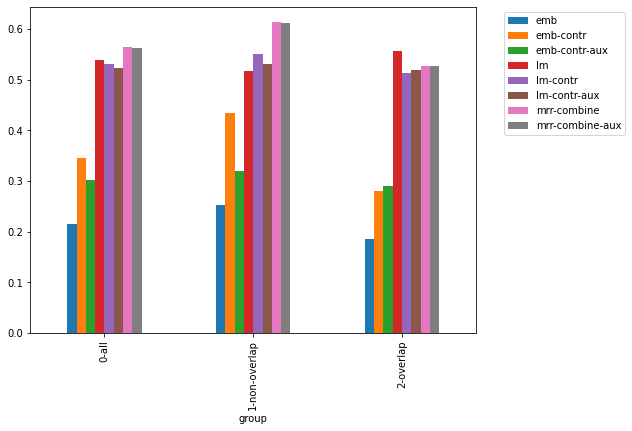

In [399]:
# _df_plot = _eval_df_a[_eval_df_a.apply(lambda row: row['method'] != 'mrr-combine', axis=1)]
_df_plot = _eval_df_a
df_pivot_difficulty = pivot_df(_df_plot, "acc", "group", "method")
df_pivot_difficulty.plot(kind="bar", figsize=(8,6)).legend(loc='upper left',ncol=1,bbox_to_anchor=(1.05, 1))

## Dump (expanded) entities

In [110]:
ee_pred_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_mrr_combine_k=None.csv')
ee_df = pd.read_csv(ee_pred_path)
ee_df.shape

(112322, 3)

In [112]:
concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
instances_dict = dict(zip(concepts_df['alignedCategoryName'].tolist(),
                      concepts_df['seedInstances'].tolist()))
instances_dict

{'company': ['walmart', 'amazon', 'subway', 'microsoft', 'target'],
 'dress_code': ['business casual',
  'uniform',
  'hair color',
  'tattoos',
  'facial hair',
  'shoes',
  'piercings'],
 'job_position': ['delivery driver',
  'store manager',
  'cashier',
  'package handler',
  'sales associate',
  'barista',
  'dishwasher'],
 'pay_schedule': ['weekly', 'biweekly', 'friday', 'saturday'],
 'benefits': ['health insurance',
  'flexible schedule',
  '401k',
  'paid vacation',
  'sick leave',
  'vision insurance'],
 'compensation': ['base pay',
  'stock options',
  'benefits',
  'overtime pay',
  'bonus'],
 'payment_option': ['checks', 'direct deposit', 'prepaid card'],
 'background_screening': ['drug test',
  'criminal background check',
  'employment verification'],
 'person': ['felons',
  'criminals',
  'disabled',
  'drug addicts',
  'high schoolers',
  'misdemeanor',
  'pregnant',
  'students',
  'seniors'],
 'hire_prerequisite': ['hiring age',
  'bachelors degree',
  'prior experien

In [114]:
K = 20
for cc, e_list in instances_dict.items():
    e_list = list(set(e_list + ee_df[ee_df['concept'] == cc]['neighbor'].tolist()[:K]))
    instances_dict[cc] = e_list
[(cc, len(e_list)) for cc, e_list in instances_dict.items()]

[('company', 23),
 ('dress_code', 25),
 ('job_position', 22),
 ('pay_schedule', 21),
 ('benefits', 23),
 ('compensation', 21),
 ('payment_option', 21),
 ('background_screening', 21),
 ('person', 25),
 ('hire_prerequisite', 22),
 ('shifts', 23),
 ('schedule', 25),
 ('employee_type', 20),
 ('onboarding_steps', 25)]

In [117]:
instances_dict_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/expanded_mrr_combine_k=20.json')
with open(instances_dict_path, 'w') as f:
    json.dump(instances_dict, f, indent=4)

# LM probes

## Probability-based

In [37]:
lm_probe_gpt2 = LMProbe_GPT2()

In [38]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(1356, 3)

### has_dress_code

In [39]:
_r = 'has_dress_code'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

company dress_code


In [40]:
_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
_seed_heads, _seed_tails

(['walmart', 'amazon', 'subway', 'microsoft', 'target'],
 ['business casual',
  'uniform',
  'hair color',
  'tattoos',
  'facial hair',
  'shoes',
  'piercings'])

In [42]:
_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
len(_cand_heads), len(_cand_tails)

(97, 94)

In [ ]:
_template = 'walmart allows [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

In [ ]:
# Microsoft 
_template = 'microsoft allows [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

### has_background_screening

In [88]:
_r = 'has_background_screening'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
print(_seed_heads, _seed_tails)

_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
print(len(_cand_heads), len(_cand_tails))

company background_screening
['walmart', 'amazon', 'subway', 'microsoft', 'target'] ['drug test', 'criminal background check', 'employment verification']
97 98


In [ ]:
# Microsoft 
_template = 'microsoft checks for [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

In [ ]:
_template = 'microsoft checks for drugs, [MASK] and felonies.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

## PMI-based

In [73]:
lm_probe_pmi = LMProbe_PMI()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### has_dress_code

In [ ]:
_template = '[HEAD] allows dress code [TAIL].'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='walmart', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

In [ ]:
# To generate prompts? (not working: high-PMI prompts not ruling out "close" wrong entities)

_template = 'microsoft allows [HEAD] [TAIL].'
_res = []

for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='jeans', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

In [ ]:
_template = 'microsoft allows [HEAD] [TAIL].'
_res = []

for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='business casual', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

In [ ]:
_template = '[HEAD] allows [TAIL] clothing.'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='microsoft', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

## LM correlation-based

### BERT

In [226]:
# corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

# with open(corpus_path, 'r') as f:
#     sent_dicts = [json.loads(l) for l in f]

In [227]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [228]:
# input_file_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sent_segmentation.txt')
# ent_freq, dedup_context = get_masked_contexts(input_file_path)

corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')

entities, dedup_context = get_masked_contexts(corpus_path, embed_num_path)

In [229]:
len(entities), len(set(entities)), len(dedup_context)

(8064, 8064, 7921)

In [230]:
all_ents_tokenized = [tuple(lm_probe.tokenizer.tokenize(e)) for e in entities]
all_ents_tokenized = list(set(all_ents_tokenized))
[sum([len(e_t) == _l for e_t in all_ents_tokenized]) for _l in (1,2,3,4,5)]

[2372, 4132, 1144, 314, 55]

In [247]:
## TODO: keep rank in output

def entity_expansion_corr(seed_concepts_path=seed_aligned_concepts_path,
                          all_contexts=dedup_context, 
                          all_ents_tokenized=all_ents_tokenized, 
                          lm_probe=lm_probe,
                          max_allowed_ngrams=3,
                          max_contexts=50,
                          top_k=100):
    if lm_probe is None:
        lm_probe = LMProbe()
        
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    
#     if contexts is None:
#         try:
#             contexts = dedup_context[entity]
#         except KeyError:
#             print(f'"{entity}" not an extracted entity!')
#             return None

    _out_records = []

    for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), total=seed_concepts_df.shape[0]):
        _expand_set = set()
        _expand_records = []
        
        for _inst in seed_instances:
            print(f'{a_concept} :: {_inst}')
            try:
                contexts = all_contexts[_inst]
            except KeyError:
                print(f'"{_inst}" not an extracted entity!')
                continue
            if len(contexts) < 2:
                print(f'"{_inst}" only have {len(contexts)} context')
                continue

            _entity_pieces = lm_probe.tokenizer.tokenize(_inst)
            if len(_entity_pieces) > max_allowed_ngrams:
                print(f'{_entity_pieces} too many word pieces (max {max_allowed_ngrams})')
                continue

            entity2probs = defaultdict(list)

            for _context in contexts[:max_contexts]:
                for n_grams in range(1, max_allowed_ngrams+1):
                    _ctxt = _context.replace('[MASK]', '[MASK]' + ' [MASK]' * (n_grams-1))
                    _ctxt = '[CLS] ' + _ctxt + ' [SEP]'
                    _cands = [e_t for e_t in all_ents_tokenized if len(e_t) == n_grams]
                    _cand_scores = lm_probe.score_candidates(_ctxt, _cands)

                    for _d in _cand_scores:
                        _c = ' '.join(_d['cand']).replace(' ##', '')
                        _s = _d['score']
                        entity2probs[_c].append(_s)

        #     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
            for _e, _ss in entity2probs.items():
                assert len(_ss) == len(entity2probs[_inst]), \
                    f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}\n\
                    len(_ss) = {len(_ss)}\n\
                    len(entity2probs["{entity}"]) = {len(entity2probs[entity])}'

            _target_ss = entity2probs[_inst]
            _target_ss = _target_ss / np.sum(_target_ss)

        #     print(_target_ss.shape, _target_ss)

            mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
            mean_l.sort(key=lambda p : p[-1], reverse=True)
            kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
            kl_l.sort(key=lambda p : p[-1], reverse=False)
            pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
            pearson_l.sort(key=lambda p : p[-1], reverse=True)

            entity2ranks = defaultdict(list)
            entity2scores = defaultdict(dict)
            for i, (_e, _s) in enumerate(mean_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["mean"] = _s
            for i, (_e, _s) in enumerate(kl_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["kl"] = _s
            for i, (_e, _s) in enumerate(pearson_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["pearson"] = _s
            # To simile top-k set intersection, keep the highest rank of _e among each criteria
            entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
            entity_overall_ranks.sort(key=lambda p : p[-1])
            entity_overall_ranks_dict = dict(entity_overall_ranks)
#             # Now, the top-k is for the final selection, not for each criteria
            sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]

#             ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
#             ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
#             ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]

#             return {
#                 "entity2probs": entity2probs,
#                 "mean_l": mean_l,
#                 "kl_l": kl_l,
#                 "pearson_l": pearson_l,
#                 "sel_entities": sel_entities,
#                 "ints_mean_l": ints_mean_l,
#                 "ints_kl_l": ints_kl_l,
#                 "ints_pearson_l": ints_pearson_l,
#             }

            for _e in sel_entities:
                if (_e in _expand_set) or (_e in seed_instances):
                    continue
                _expand_set.add(_e)
                _d = dict(entity2scores[_e])
                _d['max_rank'] = entity_overall_ranks_dict[_e]
                _expand_records.append((_e, _d))

#         for _inst in seed_instances:
#             _expand_set.discard(_inst)

        for _e, _d in _expand_records:
            _out_d = dict(_d)
            _out_d['concept'] = a_concept
            _out_d['neighbor'] = _e
            _out_records.append(_out_d)

    return _out_records

#### full run & save

In [248]:
corr_expansion_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_corr_100.csv')

In [ ]:
entity_expansion_corr(max_contexts=5)

In [ ]:
# Use scripts
!python compute_EE_corr.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/concept_corr_100.csv \
-ng 3 \
-ct 50 \
-top_k 100

#### observations

In [20]:
_entity = 'health insurance'
_results = entity_expansion_multiways(_entity)

In [216]:
len(_results['sel_entities']), _results['sel_entities']

20

In [ ]:
entity2probs = _results['entity2probs']
_ser1 = entity2probs['paid vacation']
_ser2 = entity2probs['training class']
_ser3 = entity2probs['cash office']

_ser1 = (_ser1 - min(_ser1)) / (max(_ser1) - min(_ser1))
_ser2 = (_ser2 - min(_ser2)) / (max(_ser2) - min(_ser2))
_ser3 = (_ser3 - min(_ser3)) / (max(_ser3) - min(_ser3))

list(zip(dedup_context['paid vacation'], _ser1, _ser2, _ser3))

### GPT2

In [10]:
lm_probe_gpt2 = LMProbe_GPT2()

In [13]:
def entity_expansion_multiways_GPT2(entity, 
                                    contexts=None, 
                                    entities=entities, 
                                    lm_probe=lm_probe_gpt2, 
                                    top_k=20):
    if lm_probe is None:
        lm_probe = LMProbe_GPT2()
    if contexts is None:
        contexts = dedup_context[entity]
    
    # test: speed up x100
    entities = entities[::100]
    
    entity2probs = defaultdict(list)

    for _context in tqdm(contexts[:50]):
        _cand_scores = lm_probe.score_candidates(_context, entities)

        for _d in _cand_scores:
            _c = _d['cand']
            _s = _d['score']
            entity2probs[_c].append(_s)
    
#     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
    for _e, _ss in entity2probs.items():
        assert len(_ss) == len(entity2probs[entity]), \
            f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}; len(_ss): {len(_ss)}'
    
    _target_ss = entity2probs[entity]
    _target_ss = _target_ss / np.sum(_target_ss)
    
    mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
    mean_l.sort(key=lambda p : p[-1], reverse=True)
    kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
    kl_l.sort(key=lambda p : p[-1], reverse=False)
    pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
    pearson_l.sort(key=lambda p : p[-1], reverse=True)
    
    entity2ranks = defaultdict(list)
    for i, (_e, _s) in enumerate(mean_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(kl_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(pearson_l):
        entity2ranks[_e].append(i)
    # To simile top-k set intersection, keep the highest rank of _e among each criteria
    entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
    entity_overall_ranks.sort(key=lambda p : p[-1])
    # Now, the top-k is for the final selection, not for each criteria
    sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]
    
#     mean_set = set([_e for _e, _s in mean_l[:top_k]])
#     kl_set = set([_e for _e, _s in kl_l[:top_k]])
#     pearson_set = set([_e for _e, _s in pearson_l[:top_k]])
    
#     sel_entities = mean_set & kl_set & pearson_set
    ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
    ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
    ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]
    
    return {
        "entity2probs": entity2probs,
        "mean_l": mean_l,
        "kl_l": kl_l,
        "pearson_l": pearson_l,
#         "mean_set": mean_set,
#         "kl_set": kl_set,
#         "pearson_set": pearson_set,
        "sel_entities": sel_entities,
        "ints_mean_l": ints_mean_l,
        "ints_kl_l": ints_kl_l,
        "ints_pearson_l": ints_pearson_l,
    }
    

In [ ]:
_entity = 'health insurance'
_results = entity_expansion_multiways_GPT2(_entity)

## BERT greedy-filling

In [1]:
# In lm_probes.py

# Relation Extraction Baselines
Currently only for single relation. TODO: include all relations

## Null baseline - Cartesian product

In [164]:
# Use script 
!python relation_extraction_cartesian.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-aux-EE=emb_contr-K=100-RE=Ct.csv \
-cknn $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_k=None.csv \
-topk 100

company 	 pay_schedule
company 	 dress_code
company 	 background_screening
company 	 benefits
company 	 person
company 	 compensation
company 	 hire_prerequisite
company 	 schedule
company 	 employee_type
company 	 onboarding_steps
company 	 shifts
company 	 job_position
company 	 payment_option
job_position 	 background_screening
job_position 	 hire_prerequisite
job_position 	 employee_type
job_position 	 onboarding_steps


In [249]:
# Use script 
!python relation_extraction_cartesian.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-aux-EE=mrr_combine-K=20-RE=Ct.csv \
-cknn $base_dir/data/$data_ac/intermediate/ee_mrr_combine_k=None.csv \
-topk 20

company 	 pay_schedule
company 	 dress_code
company 	 background_screening
company 	 benefits
company 	 person
company 	 compensation
company 	 hire_prerequisite
company 	 schedule
company 	 employee_type
company 	 onboarding_steps
company 	 shifts
company 	 job_position
company 	 payment_option
job_position 	 background_screening
job_position 	 hire_prerequisite
job_position 	 employee_type
job_position 	 onboarding_steps


## Relation Extraction - scores weighted average

In [ ]:
# Use script 
!python relation_extraction_avg_scores.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-r has_benefits \
-cknn $base_dir/data/$data_ac/intermediate/concept_knn_1000.csv \
-topk 300 \
-dim 768


## Relation Extraction - LM scoring (full run)

In [ ]:
# Use script 
!python relation_extraction_LM.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=LM_bert+seeds.csv \
-r has_benefits \
-ee $base_dir/data/$data_ac/intermediate/concept_knn_100.csv \
-lm bert \
-ex seeds \
-topk 3000 \
-dim 768


In [ ]:
!python relation_extraction_LM.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=LM_pmi.csv \
-r has_benefits \
-ee $base_dir/data/$data_ac/intermediate/concept_knn_100.csv \
-lm pmi \
-topk 300 \
-dim 768

## Relation Extraction Evaluation

### has_dress_code

In [171]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-EE=LM_bert-RE=Ct.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 10000
Intersection: 6
P = 0.0006, R = 0.0561, F1 = 0.0012

Intersection:
('subway', 'has_dress_code', 'piercings')
('walmart', 'has_dress_code', 'black jeans')
('walmart', 'has_dress_code', 'blue collar')
('walmart', 'has_dress_code', 'face tattoos')
('walmart', 'has_dress_code', 'jeans')
('walmart', 'has_dress_code', 'uniform')



In [170]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 203
Intersection: 4
P = 0.0197, R = 0.0374, F1 = 0.0258

Intersection:
('subway', 'has_dress_code', 'piercings')
('walmart', 'has_dress_code', 'black jeans')
('walmart', 'has_dress_code', 'jeans')
('walmart', 'has_dress_code', 'uniform')



### has_benefits

In [93]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=Ct.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 10404
Intersection: 9
P = 0.0009, R = 0.1607, F1 = 0.0017

Intersection:
('burger king', 'has_benefits', 'health')
('burger king', 'has_benefits', 'sick leave')
('dollar general', 'has_benefits', 'health insurance')
('g4s', 'has_benefits', 'sick leave')
('starbucks', 'has_benefits', 'health')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', 'life insurance')
('walmart', 'has_benefits', 'paid vacations')



In [169]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 334
Intersection: 6
P = 0.0180, R = 0.1071, F1 = 0.0308

Intersection:
('starbucks', 'has_benefits', 'health')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', 'health benefits')
('walmart', 'has_benefits', 'life insurance')
('walmart', 'has_benefits', 'paid vacations')



### has_background_screening

In [131]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_background_screening-RE=Ct.csv \
-r has_background_screening

--- RE Results ---
Benchmark relations: 207
Predicted relations: 10302
Intersection: 42
P = 0.0041, R = 0.2029, F1 = 0.0080

Intersection:
('burger king', 'has_background_screening', 'credit history')
('burger king', 'has_background_screening', 'drug test')
('burger king', 'has_background_screening', 'random drug tests')
('cracker barrel', 'has_background_screening', 'credit history')
('cracker barrel', 'has_background_screening', 'criminal background')
('cracker barrel', 'has_background_screening', 'criminal background check')
('dollar general', 'has_background_screening', 'driving record')
('dollar general', 'has_background_screening', 'social security number')
('family dollar', 'has_background_screening', 'credit history')
('family dollar', 'has_background_screening', 'criminal record')
('fedex', 'has_background_screening', 'random drug test')
('geico', 'has_background_screening', 'background check')
('geico', 'has_background_screening', 'drug test')
('marshalls', 'has_background_sc

In [168]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_background_screening-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_background_screening

--- RE Results ---
Benchmark relations: 207
Predicted relations: 301
Intersection: 22
P = 0.0731, R = 0.1063, F1 = 0.0866

Intersection:
('amazon', 'has_background_screening', 'random drug testing')
('geico', 'has_background_screening', 'background check')
('geico', 'has_background_screening', 'drug test')
('subway', 'has_background_screening', 'drug testing')
('subway', 'has_background_screening', 'drug tests')
('subway', 'has_background_screening', 'urine drug test')
('target', 'has_background_screening', 'background check')
('target', 'has_background_screening', 'criminal record')
('target', 'has_background_screening', 'drug test')
('target', 'has_background_screening', 'drug tests')
('target', 'has_background_screening', 'random drug testing')
('target', 'has_background_screening', 'urine test')
('walmart', 'has_background_screening', 'background check')
('walmart', 'has_background_screening', 'blood test')
('walmart', 'has_background_screening', 'credit check')
('walmart', 'has_ba

# Knowledge Verification baseline
(finding co-occurrences of head / tail from corpus)

## Knowledge Verification

In [165]:
# Use script 
!python knowledge_verification_entail.py \
-d $base_dir/data/$data_ac/intermediate \
-in $base_dir/data/$data_ac/intermediate/rel_extraction-all-EE=mrr_combine-RE=Ct-MINI.csv \
-o_kv $base_dir/data/$data_ac/intermediate/kv_evidences-all-EE=mrr_combine-RE=Ct-MINI.json \
-o_re $base_dir/data/$data_ac/intermediate/rel_extraction-all-EE=mrr_combine-RE=Ct+KV=0.9-MINI.csv \
-r $yutong_base_dir/models/roberta-large \
-rs $yutong_base_dir/repos/Roberta_SES/checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt \
-p_kv 0.7 \
-p_re 0.9 \
--fast_skip 3

Loading files...
Finding evidence for rels: 100%|████████████████| 68/68 [00:08<00:00,  8.16it/s]


In [ ]:
# Use script 
!python knowledge_verification_entail.py \
-d $base_dir/data/$data_ac/intermediate \
-in $base_dir/data/$data_ac/intermediate/rel_extraction-aux-EE=mrr_combine-K=100-RE=Ct.csv \
-o_kv $base_dir/data/$data_ac/intermediate/kv_evidences-aux-EE=mrr_combine-K=100-RE=Ct.json \
-o_re $base_dir/data/$data_ac/intermediate/rel_extraction-aux-EE=mrr_combine-K=100-RE=Ct+KV=0.9.csv \
-r $yutong_base_dir/models/roberta-large \
-rs $yutong_base_dir/repos/Roberta_SES/checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt \
-p_kv 0.7 \
-p_re 0.9 \
--fast_skip 3

In [12]:
!grep "\"pharmacy\"" $base_dir/data/$data_ac/intermediate/kv_evidences-aux-EE=mrr_combine-RE=Ct.json

{"relation": ["walmart", "has_job_position", "pharmacy"], "pos_evidences": [["walmart : walmart trains the associate to work in the pharmacy .", "walmart hires pharmacy .", 0.9363555312156677], ["walmart : and that \u2019s 7 people in orientation with no drug test i believe they only test for management and pharmacy and auto tech", "walmart hires pharmacy .", 0.9160915017127991], ["walmart :   one of the cashier 's recently transferred over to the pharmacy department .", "walmart hires pharmacy .", 0.9088402986526489], ["walmart : walmart does not drug test in ohio except for certain positions such as pharmacy , maintenance , automotive , lawn and garden , and vision center .", "walmart hires pharmacy .", 0.897567629814148], ["walmart : dairy , hardware , sporting goods , garden , cosmetics , pharmacy , toys , electronics , infants , shoes , apparel , grocery , seasonal , cashier , security(ap )", "walmart hires pharmacy .", 0.8961710929870605], ["walmart : \n thier is no reason for me

## KV analysis: multi-supporting?

In [6]:
roberta_ses_dir = os.path.join(yutong_base_dir, "repos", "Roberta_SES")

# 0 = contra, 1 = neutral, 2 = entail
entailment_model = Roberta_SES_Entailment(roberta_path='/home/ubuntu/users/yutong/models/roberta-large',
        ckpt_path=os.path.join(roberta_ses_dir, 'checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt'),
        max_length=512,
        device_name='cpu')


In [7]:
entailment_model.predict(
    'walmart : we have to wear uniform',
    'walmart requires uniform'
)

(tensor(2), tensor([0.0019, 0.0084, 0.9897]))

In [8]:
entailment_model.predict(
    'walmart : we have to wear uniform',
    'walmart offers uniform'
)

(tensor(2), tensor([0.0036, 0.0650, 0.9314]))

In [9]:
entailment_model.predict(
    'walmart : the uniform is comfortable so we like it',
    'walmart requires uniform'
)

(tensor(2), tensor([0.0146, 0.2898, 0.6956]))

In [10]:
kv_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/kv_evidences-has_dress_code-RE=Ct.json')
templates_path = os.path.join(base_dir, f'src/concept_learning/templates_manual.json')

with open(kv_path, 'r') as f:
    kv_dicts = [json.loads(l) for l in f]
with open(templates_path, 'r') as f:
    all_templates = json.load(f)
    
len(kv_dicts), all_templates.keys()

(2779,
 dict_keys(['has_job_position', 'has_benefits', 'has_pay_schedule', 'has_dress_code', 'has_background_screening', 'hires_person']))

In [11]:
kv_dicts[0]

{'relation': ['walmart', 'has_dress_code', 'business casual'],
 'pos_evidences': [['walmart : business casual with a walmart vest',
   'walmart requires business casual',
   0.9809538125991821],
  ['walmart : i was told “ business casual ” ... any colored shirt ( no logo or pictures ) , jeans or pants and close toed shoes .',
   'walmart allows business casual',
   0.8808652758598328]],
 'neg_evidences': []}

In [14]:
_multi_supporting_evs = []

for d in tqdm(kv_dicts[::500]):
    head, rel, tail = d['relation']
    pos_evs = d['pos_evidences']
    neg_evs = d['neg_evidences']
    good_evs = [ev for ev in pos_evs + neg_evs if ev[-1] > 0.9]
    if len(good_evs) == 0:
        continue
    
    for ev_tuple in good_evs:
        ev_sent, ev_hyp, score = ev_tuple
        _supports = [(rel, ev_hyp, score)] # what are the relations supported 
        for _r, (_p_templates, _n_templates) in all_templates.items():
            if _r == rel:
                continue

            _templates = _p_templates + _n_templates
            for _tmpl in _templates:
                _hyp = _tmpl.format(head, tail)
                _score = entailment_model.predict(ev_sent, _hyp)[1][2].item()
                if _score > 0.9:
                    _supports.append((_r, _hyp, _score))
                    break
    
        if len(_supports) > 1:
            _multi_supporting_evs.append((ev_sent, _supports))


In [15]:
_multi_supporting_evs

[]

## KV feedback to EE

### Single-relation verify

In [264]:
# has_dress_code: company / dress_code 
kv_rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-aux-EE=mrr_combine-K=20-RE=Ct+KV=0.9.csv')
kv_ee_output_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/kv_entities-aux-EE=mrr_combine-K=20-RE=Ct+KV=0.9.csv')


In [265]:
kv_rels = pd.read_csv(kv_rels_path)
kv_rels.shape

(1085, 3)

In [266]:
seed_relations = load_seed_aligned_relations(seed_aux_relations_path)
seed_relation_dicts = seed_relations.to_dict('record')

rel_h_types_dict = dict([(_d['alignedRelationName'], _d['domain']) for _d in seed_relation_dicts])
rel_t_types_dict = dict([(_d['alignedRelationName'], _d['range']) for _d in seed_relation_dicts])

In [267]:
cc_ents_dict = defaultdict(set)

for _d in kv_rels.to_dict('record'):
    _rel = _d['relation']
    _h_type = rel_h_types_dict[_rel]
    _t_type = rel_t_types_dict[_rel]
    _h = _d['head']
    _t = _d['tail']
    cc_ents_dict[_h_type].add(_h)
    cc_ents_dict[_t_type].add(_t)
    

In [268]:
_records = [{'concept': _cc, 'neighbor': _e} for _cc, _e_set in cc_ents_dict.items() for _e in _e_set]
pd.DataFrame(_records).to_csv(kv_ee_output_path, index=False)

In [254]:
# postprocess to get kv-ee results for lower K 
kv_rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-aux-EE=mrr_combine-K=100-RE=Ct+KV=0.9.csv')
rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-aux-EE=mrr_combine-K=20-RE=Ct.csv')
out_kv_rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-aux-EE=mrr_combine-K=20-RE=Ct+KV=0.9.csv')

In [255]:
_cand_rels = [(d['head'], d['relation'], d['tail']) for d in pd.read_csv(rels_path).to_dict('record')]
_cand_rels = set(_cand_rels)
len(_cand_rels)

6800

In [256]:
_kv_rels = pd.read_csv(kv_rels_path).to_dict('record')
print(len(_kv_rels))
_kv_rels = [d for d in _kv_rels if (d['head'], d['relation'], d['tail']) in _cand_rels]
print(len(_kv_rels))

12100
1085


In [257]:
pd.DataFrame(_kv_rels).to_csv(out_kv_rels_path, index=None)

In [ ]:
# eval (old)
_all_concepts, _all_rel_tuples = load_benchmark(benchmark_full_path=benchmark_path,
                                                seed_concepts_path=seed_aligned_concepts_path,
                                                seed_relations_path=seed_aligned_relations_path)

In [133]:
len(_all_concepts['company']), len(kv_heads)

(105, 93)

In [134]:
len(kv_heads & _all_concepts['company'])

48

In [135]:
kv_heads & _all_concepts['company']

{'amazon',
 'at&t',
 'best buy',
 'burger king',
 'chipotle',
 'costco',
 'cracker barrel',
 'cvs',
 'dd',
 'dollar general',
 'dollar tree',
 'dunkin donuts',
 'family dollar',
 'fedex',
 'frito lay',
 'g4s',
 'geico',
 'hobby lobby',
 'home depot',
 'ihop',
 'jcpenney',
 'kfc',
 'kroger',
 'little caesars',
 'marshalls',
 'mcdonalds',
 'menards',
 'old navy',
 'olive garden',
 'panera bread',
 'pepsico',
 'petsmart',
 'pizza hut',
 'planet fitness',
 'publix',
 'safeway',
 'sitel',
 'spectrum',
 'starbucks',
 'subway',
 'taco bell',
 'target',
 'tj maxx',
 'training',
 'verizon',
 'walgreens',
 'walmart',
 'wells fargo'}

In [136]:
# compare 
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
concept_knn_df = pd.read_csv(concept_knn_path)
_knn_entities = set(concept_knn_df[concept_knn_df['concept'] == 'company']['neighbor'].tolist())
len(_knn_entities)

97

In [139]:
seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
_seed_entities = set(seed_concepts_df[seed_concepts_df['alignedCategoryName'] == 'company']['seedInstances'].item())
_seed_entities

{'amazon', 'microsoft', 'subway', 'target', 'walmart'}

In [141]:
_combine_entities = set(_seed_entities) | _knn_entities
len(_combine_entities)

102

In [143]:
len(_combine_entities & _all_concepts['company'])

49

### Multi-relation verify

In [269]:
kv_rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-aux-EE=mrr_combine-RE=Ct+KV=0.9.csv')
ee_labels_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels.csv')

In [272]:
ee_labels_dict = load_EE_labels(ee_labels_path)
ee_labels_dict.keys()

dict_keys(['schedule', 'benefits', 'pay_schedule', 'employee_type', 'job_position', 'company', 'hire_prerequisite', 'compensation', 'payment_option', 'dress_code', 'person', 'shifts', 'onboarding_steps', 'background_screening'])

In [251]:
kv_rels = pd.read_csv(kv_rels_path)
kv_rels.shape

(4209, 3)

In [254]:
_instance = 'general store'
list(set(kv_rels[kv_rels['head'] == _instance]['relation'].tolist()))

[]

In [ ]:
kv_rels_records = kv_rels.to_dict('records')

In [257]:
kv_companies = list(set([d['head'] for d in kv_rels_records if not d['relation'].startswith('position')]))
kv_companies

['walmart',
 'google',
 'costco',
 'best buy',
 'wal mart',
 'walgreens',
 'publix',
 'verizon',
 'nike',
 'apple',
 'dollar general',
 'kroger',
 'pepsico',
 'jcpenney',
 'pepsi',
 'geico',
 'amazon',
 'cracker barrel',
 'sears',
 'family dollar',
 'target corporation',
 'sitel',
 'frito lay',
 'target',
 'spectrum',
 'g4s',
 'starbucks',
 'old navy',
 'subway',
 'home depot',
 'facebook',
 't mobile',
 'panera bread',
 'whole foods']

In [277]:
len(kv_companies), len(set(kv_companies) & set(ee_labels_dict['company']))

(34, 34)

In [278]:
kv_positions = list(set([d['head'] for d in kv_rels_records if d['relation'].startswith('position')]))
kv_positions

['general manager',
 'key holder',
 'store manager',
 'bartender',
 'assistant store manager',
 'beauty advisor',
 'team leader',
 'sales representative',
 'courtesy clerk',
 'chef',
 'carrier',
 'crew member',
 'nurse',
 'manager',
 'store director',
 'barista',
 'package handler',
 'pharmacy',
 'office assistant',
 'driver helper',
 'pharmacist',
 'head cashier',
 'delivery driver',
 'shift lead',
 'shift leader',
 'line cook',
 'cashier',
 'trainer',
 'sales associate',
 'assistant manager',
 'sales rep',
 'team member',
 'seasonal employee',
 'dishwasher',
 'sales consultant',
 'shift supervisor']

In [280]:
len(kv_positions), len(set(kv_positions) & set(ee_labels_dict['job_position'])), \
[_e for _e in kv_positions if _e not in ee_labels_dict['job_position']]

(36, 33, ['pharmacy', 'team member', 'seasonal employee'])

In [258]:
kv_hire_prers = list(set([d['tail'] for d in kv_rels_records if d['relation'].endswith('prerequisite')]))
kv_hire_prers

['technical support',
 'training',
 'construction',
 'legal age',
 'personal vehicle',
 'age requirements',
 'additional training',
 'heavy equipment',
 'memory',
 'food handlers card',
 'job title',
 'minimum age',
 'driver license',
 'diploma',
 'youngest age',
 'permit',
 'working permit',
 'insurance',
 'personal experience',
 'passport',
 'working papers',
 'previous experience',
 'age requirement',
 'clean driving record',
 'hiring age',
 'safety',
 'workers permit',
 'food safety',
 'employment',
 'transport',
 'accounting',
 'prior experience',
 'high school diploma',
 "bachelor 's degree",
 'medical insurance',
 'power equipment',
 'heavy lifting',
 'drivers license',
 'degree',
 'back ground check',
 'bachelors degree',
 'clean record',
 'age limit']

In [266]:
_rel_counter = Counter()
_concept = 'hire_prerequisite'
_target_rels = ['has_hire_prerequisite', 'position_has_hire_prerequisite']

for _r in _target_rels:
    _ents = list(set([d['tail'] for d in kv_rels_records if d['relation'] == _r]))
    _rel_counter.update(_ents)

In [268]:
_rel_counter.most_common()

[('training', 2),
 ('age requirements', 2),
 ('job title', 2),
 ('minimum age', 2),
 ('driver license', 2),
 ('diploma', 2),
 ('permit', 2),
 ('insurance', 2),
 ('previous experience', 2),
 ('clean driving record', 2),
 ('safety', 2),
 ('food safety', 2),
 ('employment', 2),
 ('transport', 2),
 ('prior experience', 2),
 ('high school diploma', 2),
 ("bachelor 's degree", 2),
 ('heavy lifting', 2),
 ('drivers license', 2),
 ('degree', 2),
 ('back ground check', 2),
 ('bachelors degree', 2),
 ('age limit', 2),
 ('technical support', 1),
 ('construction', 1),
 ('legal age', 1),
 ('additional training', 1),
 ('heavy equipment', 1),
 ('memory', 1),
 ('food handlers card', 1),
 ('youngest age', 1),
 ('working permit', 1),
 ('personal experience', 1),
 ('passport', 1),
 ('working papers', 1),
 ('age requirement', 1),
 ('hiring age', 1),
 ('workers permit', 1),
 ('accounting', 1),
 ('medical insurance', 1),
 ('power equipment', 1),
 ('clean record', 1),
 ('personal vehicle', 1)]

In [276]:
_target_cnts = [1, 2]
for _cnt in _target_cnts:
    _ents = [_e for _e, _c in _rel_counter.items() if _c == _cnt]
    _corr_ents = set(_ents) & set(ee_labels_dict[_concept])
    print(f'{_cnt} relation(s): {len(_corr_ents)} / {len(_ents)}')

1 relation(s): 16 / 20
2 relation(s): 16 / 23


In [284]:
_rel_counter = Counter()
_concept = 'job_position'

_target_head_rels = ['position_has_hire_prerequisite', 'position_has_background_screening', 'position_has_employee_type', 'position_has_onboarding_steps']
_target_tail_rels = ['has_job_position']

for _r in _target_head_rels:
    _ents = list(set([d['head'] for d in kv_rels_records if d['relation'] == _r]))
    _rel_counter.update(_ents)
for _r in _target_tail_rels:
    _ents = list(set([d['tail'] for d in kv_rels_records if d['relation'] == _r]))
    _rel_counter.update(_ents)
    

In [285]:
_target_cnts = [1, 2, 3, 4, 5]
for _cnt in _target_cnts:
    _ents = [_e for _e, _c in _rel_counter.items() if _c == _cnt]
    _corr_ents = set(_ents) & set(ee_labels_dict[_concept])
    print(f'{_cnt} relation(s): {len(_corr_ents)} / {len(_ents)}')

1 relation(s): 9 / 9
2 relation(s): 6 / 6
3 relation(s): 2 / 3
4 relation(s): 11 / 11
5 relation(s): 11 / 13


In [287]:
_rel_counter.most_common()

[('general manager', 5),
 ('key holder', 5),
 ('store manager', 5),
 ('carrier', 5),
 ('crew member', 5),
 ('manager', 5),
 ('pharmacy', 5),
 ('delivery driver', 5),
 ('shift leader', 5),
 ('cashier', 5),
 ('sales associate', 5),
 ('assistant manager', 5),
 ('team member', 5),
 ('team leader', 4),
 ('barista', 4),
 ('package handler', 4),
 ('driver helper', 4),
 ('shift lead', 4),
 ('dishwasher', 4),
 ('shift supervisor', 4),
 ('assistant store manager', 4),
 ('beauty advisor', 4),
 ('trainer', 4),
 ('sales consultant', 4),
 ('nurse', 3),
 ('pharmacist', 3),
 ('seasonal employee', 3),
 ('bartender', 2),
 ('sales representative', 2),
 ('courtesy clerk', 2),
 ('store director', 2),
 ('line cook', 2),
 ('sales rep', 2),
 ('office assistant', 1),
 ('chef', 1),
 ('head cashier', 1),
 ('medical assistant', 1),
 ('prep cook', 1),
 ('night stocker', 1),
 ('beauty consultant', 1),
 ('store manger', 1),
 ('sales specialist', 1)]

In [293]:
!grep "\"team member\", \"position_has_onboarding_steps\"" $base_dir/data/$data_ac/intermediate/kv_evidences-aux-EE=mrr_combine-RE=Ct.json

{"relation": ["team member", "position_has_onboarding_steps", "orientation"], "pos_evidences": [["target : new \" team member \" orientation is basically your first day at work , so you are paid for those hours you are there being trained and introduced to the store / facility ( usually about 4 hours ) .", "There is orientation for team member .", 0.9881517291069031], ["chili's : this definitely means you 've secured a spot as a team member or employee because they are preparing you for training through the orientation to give you a feel of what you are about to get into .", "There is orientation for team member .", 0.9758924841880798]], "neg_evidences": []}
{"relation": ["team member", "position_has_onboarding_steps", "training"], "pos_evidences": [["chili's : this definitely means you 've secured a spot as a team member or employee because they are preparing you for training through the orientation to give you a feel of what you are about to get into .", "team member can get training

## Auxiliary relations for inference

### Find auxiliary relations

In [162]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')
with open(corpus_path, 'r') as f:
    sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]
len(sent_dicts)

413232

In [178]:
instances_dict_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/expanded_mrr_combine_k=20_clean.json')
with open(instances_dict_path, 'r') as f:
    instances_dict = json.load(f)
len(instances_dict)

14

In [164]:
_h = 'chef'  # proxy for company 
_t = 'uniform'

_mentions = []
for d in sent_dicts:
    if _h in d['entities'] and _t in d['entities']:
        _mentions.append(' '.join(d['tokens']))

len(_mentions), _mentions[:3]

(1,
 ["The night maintenance uniform is a chef 's coat , with black pants , and non - slip shoes ."])

In [165]:
_h_cc = 'job_position'
_t_cc = 'dress_code'

_mentions = []
for d in tqdm(sent_dicts):
    _has_h = False
    _has_t = False
    for _e in d['entities']:
        if not _has_h and _e in instances_dict[_h_cc]:
            _has_h = True
        if not _has_t and _e in instances_dict[_t_cc]:
            _has_t = True
    if _has_h and _has_t:
        _mentions.append(' '.join(d['tokens']))
        
#     for _h in instances_dict[_h_cc]:
#         if _h not in d['entities']:
#             continue
#         for _t in instances_dict[_t_cc]:
#             if _t in d['entities']:
#                 _mentions.append(' '.join(d['tokens']))

len(_mentions), _mentions[:3]

(54,
 ['I am sure there is always a need for   employees and quite honestly you can find a positon that fits you because the is a huge volume   of everything in the clothing , retail , cashier gift cards and have ahuge parking lot close to condominuim and several offices .',
  "The night maintenance uniform is a chef 's coat , with black pants , and non - slip shoes .",
  'BUT in my store the district manager and store manager do not mind very small nose piercings'])

In [174]:
_h_cc = 'benefits'
_t_cc = 'hire_prerequisite'

_mentions = []
for d in tqdm(sent_dicts):
#     _has_h = False
#     _has_t = False
#     for _e in d['entities']:
#         if not _has_h and _e in instances_dict[_h_cc]:
#             _has_h = True
#         if not _has_t and _e in instances_dict[_t_cc]:
#             _has_t = True
#     if _has_h and _has_t:
    _e_set = set(d['entities'])
    _h_ents = set(instances_dict[_h_cc]) & _e_set
    _t_ents = set(instances_dict[_t_cc]) & _e_set
    if len(_h_ents) == 0:
        continue
    if len(_t_ents) == 0:
        continue
    if _h_ents.issubset(_t_ents) or _t_ents.issubset(_h_ents): 
        continue
    print(_h_ents, '|', _t_ents)
    _mentions.append(' '.join(d['tokens']))

len(_mentions), _mentions[:3]

{'health care', 'health'} | {'employment'}
{'education'} | {'employment'}
{'401k', 'medical'} | {'training'}
{'health'} | {'safety'}
{'education'} | {'employment'}
{'insurance', 'health insurance', 'health'} | {'insurance', 'employment'}
{'education'} | {'employment'}
{'medical'} | {'employment'}
{'education'} | {'employment'}
{'education'} | {'employment'}
{'education'} | {'employment'}
{'insurance', 'health insurance', 'health'} | {'insurance', 'employment'}
{'medical'} | {'employment'}
{'disability'} | {'training'}
{'health'} | {'safety'}
{'401k'} | {'employment'}
{'health'} | {'safety'}
{'medical', 'sick leave'} | {'transport'}
{'health'} | {'training', 'safety'}
{'health'} | {'employment'}
{'medical'} | {'employment'}
{'education'} | {'safety'}
{'education'} | {'employment'}
{'health care', 'health'} | {'training'}
{'health'} | {'safety'}
{'medical', 'pension'} | {'training'}
{'sick leave'} | {'safety'}
{'health'} | {'training'}
{'insurance', 'health insurance', 'health'} | {'insu

(131,
 ['Health care and dental care is big key on looking for employment .',
  'Yes the check background on former employment and also education .',
  "Benefits include vacation pay based on time worked and length of service holiday bonus ( gift card for cracker barrel ) discount on everything in store % based on par level ( company training program ) vision dental medical life ( day 1 sign up offered for first 30 days after that open enrollment once a year ) $ 0.25 match per dollar 401k stock options ( no discount but fee 's are waived can setup too deduct from paycheck for full or partial shares ) honestly benefits are the best you will ever find in the food service industry"])

In [179]:
_mentions = [[[] for _ in instances_dict] for __ in instances_dict]
_concepts = list(instances_dict.keys())

for d in tqdm(sent_dicts):
    _e_set = set(d['entities'])
    
    for i in range(len(_concepts)):
        _h_cc = _concepts[i]
        _h_ents = set(instances_dict[_h_cc]) & _e_set
        if len(_h_ents) == 0:
            continue
        for j in range(i+1, len(_concepts)):
            _t_cc = _concepts[j]
            _t_ents = set(instances_dict[_t_cc]) & _e_set
            if len(_t_ents) == 0:
                continue
            if _h_ents.issubset(_t_ents) or _t_ents.issubset(_h_ents):
                # just entity intersection
                continue
            _mentions[i][j].append(' '.join(d['tokens']))

In [181]:
_msg = f'{"Co-occ":<10s}'
for _cc in _concepts:
    _msg += f'{_cc[:9]:^10s}'
_msg += '\n'
for i in range(len(_concepts)):
    _msg += f'{_concepts[i][:9]:<10s}'
    for j in range(len(_concepts)):
        if j == i:
            _msg += f'{"--":^10s}'
        elif j < i:
            _msg += f'{len(_mentions[j][i]):^10d}'
        else:
            _msg += f'{len(_mentions[i][j]):^10d}'
    _msg += '\n'
print(_msg)

Co-occ     company  dress_cod job_posit pay_sched  benefits compensat payment_o backgroun   person  hire_prer   shifts   schedule employee_ onboardin 
company       --       1582      1387      1664      1130      991       1052      3174      619       1864      303       1110      3102      1211   
dress_cod    1582       --        54        27        16        5         22        74        15        46        1         30        52        86    
job_posit    1387       54        --        37        21        62        34       121        13       126        18        39       292       109    
pay_sched    1664       27        37        --        19        63       407        21        3         57        31        15       174        77    
benefits     1130       16        21        19        --       237        93        79        22       112        1         8        401        34    
compensat    991        5         62        63       237        --        50        29        

In [155]:
list(enumerate(_concepts))

[(0, 'company'),
 (1, 'dress_code'),
 (2, 'job_position'),
 (3, 'pay_schedule'),
 (4, 'benefits'),
 (5, 'compensation'),
 (6, 'payment_option'),
 (7, 'background_screening'),
 (8, 'person'),
 (9, 'hire_prerequisite'),
 (10, 'shifts'),
 (11, 'schedule'),
 (12, 'employee_type'),
 (13, 'onboarding_steps')]

In [232]:
len(_mentions[2][7])

121

In [ ]:
instances_dict['job_position'], instances_dict['hire_prerequisite']

In [235]:
_mentions[2][13][::10]

["So , I responded on ESVS that I did n't get any training and complained to the assistant manager .",
 'It 2 weeks in lab to get the handle of the drink making and and then you do 2 weeks of cashier training',
 'I am in Midland TX , I have my orientation today for delivery driver / runner , the manager said about an hour long .',
 "I was told when I got hired I was going to be a store managerin training , I have been in retail for 32 years my training should have consisted of how to use Dollar Generals tools I already know how to do the job and I 'm being used and abused by the store manager right now as an assistant making $ 11 an hour to close his store every   day .",
 'What training and educational background i need to work Cashier Walgreens',
 'Apply for store manager position based off of interview and business knowledge of small box retail is where you ’ll be placed as far as Training and Store position',
 'Standard orientation for all server , cook or bartender was 5 days , wi

In [172]:
_tgt_sent = '5 hours and then training in store'
for d in sent_dicts:
    if ' '.join(d['tokens']) == _tgt_sent:
        print(d)

{'tokens': ['5', 'hours', 'and', 'then', 'training', 'in', 'store'], 'company': 'CVS Health', 'entities': ['cvs health', 'training']}


### Mine prompts for new relations

In [191]:
seed_relations_df = load_seed_aligned_relations(seed_aligned_relations_path)

In [202]:
h_concept = 'job_position'
t_concept = 'hire_prerequisite'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

In [203]:
_res

{'<src> <tgt>': ['it 2 weeks in lab to get the handle of the drink making and and then you do 2 weeks of cashier training',
  'cashier , customer service training .',
  '7.25 at time for partime cashier will training you .',
  'you \'re the " go to " for cashier training and questions .',
  'cashier training is just getting thrown into a checkstand !',
  'i was promoted from associate to shift manger in 6 months and never finished my cashier training',
  'orientation was based in some cashier training as well as online test .'],
 '<tgt> for <src>': ['yes , there is training for a cashier .',
  'do they offer training for cashier ?']}

In [215]:
h_concept = 'job_position'
t_concept = 'background_screening'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

In [216]:
_res

{'<tgt> <tgt> for <src> <src>': ['does fedex in austin tx drug test for package handler',
  'does fedex drug test for package handler in new jersey an if so when',
  'they do not drug test for a package handler',
  'does ups drug test for package handler in illinois',
  "no they do n't drug test for package handler at any location",
  'no drug test for the package handler',
  'no drug test for package handler .'],
 '<tgt> <tgt> <src> <src>': ["there 's no drug test for part - time employees package handler ..",
  "no they do n't drug test package handler at any ups locations"],
 '<tgt> <tgt> for <src> position': ["they will drug test for management positions , but they should n't for a cashier position",
  'no , there is no drug test for the overnight cashier position anymore .',
  "they use to but i do n't think they do drug test for a cashier position anymore ."],
 '<tgt> <tgt> for <src> positions': ['they do nt do drug test for cashier positions .',
  'do they drug test in idaho for

In [217]:
h_concept = 'job_position'
t_concept = 'employee_type'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

In [218]:
_res

{'<tgt> <tgt> <src> <src>': ['8.50 as a full time key holder .',
  'full time key holder   will get anywhere from   to hours per week',
  'the only people who are allowed full time are team leaders , assistant managers and store manager .',
  'cashiers take a drug test at the store while assistant managers and store manager go to a facility to get drug tested .',
  'the chances of becoming a full time crew member are high depending on your availability',
  'i was always a full time crew member',
  'weekly part time package handler',
  'you were eligible after 1000 hours as part time package handler .',
  "what 's the starting pay for a part time package handler",
  'the starting pay rate for a part time package handler is 11.00 a hour',
  'what is the pay rate for a part time package handler in fredericksburg virginia',
  'benefits are available after 30 or 90 days , if you are a part time package handler .',
  'i just got hired as a part time package handler in ft worth , tx there was

In [219]:
h_concept = 'job_position'
t_concept = 'onboarding_steps'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

In [220]:
_res

{'<src> <tgt>': ['it 2 weeks in lab to get the handle of the drink making and and then you do 2 weeks of cashier training',
  'cashier , customer service training .',
  '7.25 at time for partime cashier will training you .',
  'you \'re the " go to " for cashier training and questions .',
  'cashier training is just getting thrown into a checkstand !',
  'i was promoted from associate to shift manger in 6 months and never finished my cashier training',
  'orientation was based in some cashier training as well as online test .'],
 '<tgt> for <src>': ['yes , there is training for a cashier .',
  'do they offer training for cashier ?'],
 'manager <src> <src> leading <tgt> <tgt>': ['  if you are wanting to walk in just after the start time , be prepared for the manager or assistant manager leading the group interview to ask you to attend the next open interview , which is probably being held in the next few days .',
  '  if you are wanting to walk in just after the start time , be prepared

In [244]:
h_concept = 'benefits'
t_concept = 'compensation'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

In [246]:
_res.keys()

dict_keys(['<tgt> <src> <src>', '<src> <src> <tgt> <tgt>', '<src> <src> <tgt>', '<src> <tgt>', '<src> 401k <tgt>', '<tgt> <src>', 'health dental vision accident <tgt> <src> insurance', '<src> care <tgt>', '<src> dental <tgt>', '<src> vision <tgt>', '<tgt> <src> insurance', '<src> dental vision <tgt>', 'dental <src> <tgt>', '<src> dental vision accident <tgt>', '<src> <tgt> <tgt>', '<tgt> <tgt> <src>', '<tgt> insurance <src> <src>', 'health dental vision accident <tgt> <src> <src>', '<tgt> and <src>', '<tgt> , <src>', '<tgt> <src> match', '<src> plan <tgt>'])

In [247]:
h_concept = 'payment_option'
t_concept = 'background_screening'

_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=instances_dict[h_concept],
                                   t_instances=instances_dict[t_concept],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlapping spans
overlappin

In [248]:
_res

{'<src> <tgt>': ['no , you must have a valid id & another form of identification ( birth certificate , sos card , passport , etc )',
  'id + birth certificate or social security card or passport , direct deposit info'],
 '<src> work for <tgt> <tgt>': ['when you go in for your third interview and offer you a position , the hiring manager will give you the paper work for the drug test',
  'at the end of the second interview , i asked when they would contact me if they are interested and they handed me paper work for the drug test and background check .'],
 '<tgt> <src>': ['yes but only if you turn in your two weekends notice and sign your end of employment paper .',
  'they should have sent you an email so you can fill out all your employment paper work .',
  'i got called into dominos to finish my pre employment paper work after finishing the background check i m 16 in nc and yes when they called me they stated i will have to take a drug test curious to what test this is though will it 

# Mine Prompts

In [13]:
# Explore various techniques
# Get prompts "between" entities
# Get prompts by syntactic parsing
# Get prompts by paraphrasing
# Get prompts uisng AutoPrompt

In [14]:
# visit here: /meg-kb/src/analysis/pattern_mining.ipynb

In [15]:
_nlp = spacy.load('en_core_web_sm')

In [98]:
_sent = "Amazon is a good place for working as a part-time."
_doc = _nlp(_sent)
for _t in _doc:
    print(_t.i, _t, list(_t.children))

0 Amazon []
1 is [Amazon, place, .]
2 a []
3 good []
4 place [a, good, for]
5 for [working]
6 working [as]
7 as [time]
8 a []
9 part []
10 - []
11 time [a, part, -]
12 . []


In [99]:
edges = []
for _t in _doc:
    for child in _t.children:
        edges.append(('{}-{}'.format(_t.lower_,_t.i), '{}-{}'.format(child.lower_,child.i))) 

graph = nx.Graph(edges)
graph

In [100]:
graph.edges

EdgeView([('is-1', 'amazon-0'), ('is-1', 'place-4'), ('is-1', '.-12'), ('place-4', 'a-2'), ('place-4', 'good-3'), ('place-4', 'for-5'), ('for-5', 'working-6'), ('working-6', 'as-7'), ('as-7', 'time-11'), ('time-11', 'a-8'), ('time-11', 'part-9'), ('time-11', '--10')])

In [101]:
_src = 'amazon-0'
_tgt = 'time-11'
if nx.has_path(graph, source=_src, target=_tgt):
    path = nx.shortest_path(graph, source=_src, target=_tgt)
    print(path)

['amazon-0', 'is-1', 'place-4', 'for-5', 'working-6', 'as-7', 'time-11']


In [102]:
'amazon-0' in graph

True

In [103]:
('is-1', 'amazon-0') in graph

False

## Mine Prompts from seed

In [ ]:
_h = 'they'  # proxy for company 
_t = 'tattoos'

_mentions = []
for d in corpus:
    if _t in d['entities']:
        _mentions.append(' '.join(d['tokens']))

_res = learn_patterns(_mentions, _h, _t, nlp=_nlp)
_res

In [212]:
## TODO: put to utils.py

def mine_patterns_between_entities(corpus,
                                   h_instances,
                                   t_instances,
                                   seed_relations_df,
                                   nlp=None):

    if nlp is None:
        nlp = spacy.load('en_core_web_sm')
    
    mined_patterns = dict()
    
    tqdm_enum_pairs = tqdm([(_h, _t) for _h in h_instances for _t in t_instances])
    for _h, _t in tqdm_enum_pairs:
        tqdm_enum_pairs.set_description(f'{str((_h, _t))[:32]:<32s}', refresh=True)
        
        _mentions = []
        for d in corpus:
            _sent = ' '.join(d['tokens']).lower()
            if _h in d['entities'] and _t in d['entities']:
                _mentions.append(_sent)

        _res = learn_patterns(_mentions, _h, _t, nlp=nlp)
        for _k, _sents in _res:
            mined_patterns[_k] = mined_patterns.get(_k, []) + _sents
    
    return mined_patterns
    

In [213]:
_res = mine_patterns_between_entities(corpus=sent_dicts,
                                   h_instances=['cashier', 'store manager'],
                                   t_instances=['training', 'age limit'],
                                   seed_relations_df=seed_relations_df,
                                   nlp=nlp_full)

In [214]:
_res

{'<src> <tgt>': ['it 2 weeks in lab to get the handle of the drink making and and then you do 2 weeks of cashier training',
  'cashier , customer service training .',
  '7.25 at time for partime cashier will training you .',
  'you \'re the " go to " for cashier training and questions .',
  'cashier training is just getting thrown into a checkstand !',
  'i was promoted from associate to shift manger in 6 months and never finished my cashier training',
  'orientation was based in some cashier training as well as online test .'],
 '<tgt> for <src>': ['yes , there is training for a cashier .',
  'do they offer training for cashier ?']}

In [27]:
# Fully run - all relations, all tail entities 
## TODO: use mine_patterns_between_entities()

all_relation_patterns = dict()

for _r_row in tqdm(seed_relations_df.to_records('dict')):
    _r = _r_row['alignedRelationName']
    _h_type = _r_row['domain']
    _t_type = _r_row['range']
    
    print((_h_type, _r, _t_type))
    assert _h_type == 'company'
    
    # _seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
    _seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
    
    _r_patterns = dict()
    
    _h = 'they'
    for _t in _seed_tails:
        _mentions = []
        for d in corpus:
            _sent = ' '.join(d['tokens']).lower()
            if _h in _sent.split(' ') and _t in d['entities']:
                _mentions.append(_sent)

        _res = learn_patterns(_mentions, _h, _t, nlp=_nlp)
        for _k, _sents in _res:
            _r_patterns[_k] = _r_patterns.get(_k, []) + _sents
    
    all_relation_patterns[_r] = _r_patterns

('company', 'has_pay_schedule', 'pay_schedule')
('company', 'has_dress_code', 'dress_code')
('company', 'has_background_screening', 'background_screening')
('company', 'has_benefits', 'benefits')
('company', 'hires_person', 'person')
('company', 'has_compensation', 'compensation')
('company', 'has_hire_prerequisite', 'hire_prerequisite')
('company', 'operates_on', 'schedule')
('company', 'hires_employee_type', 'employee_type')
('company', 'has_onboarding_steps', 'onboarding_steps')
('company', 'has_shifts', 'shifts')
('company', 'has_job_position', 'job_position')
('company', 'has_payment_option', 'payment_option')



In [28]:
all_relation_patterns_sub = dict()
for _r, _patterns in all_relation_patterns.items():
    _r_patterns = dict()
    for _p, _sents in _patterns.items():
        _p_dict = {
            'count': len(_sents),
            'samples': _sents[:20]
        }
        _r_patterns[_p] = _p_dict
    all_relation_patterns_sub[_r] = _r_patterns

In [29]:
all_relation_patterns_sub['has_benefits']

{'<src> offer <tgt> <tgt>': {'count': 15,
  'samples': ['no i do nt think it would be because they do nt offer health insurance when you work part time .',
   'do they offer health insurance to full time sales associates ?',
   "they do n't offer health insurance",
   'but i hear they offer dental and health insurance .',
   'no , they do not offer health insurance or at least the one i work at does not .',
   'no they do not offer any health insurance at all',
   "  they also offer health insurance , with different plans , if you 're full time !",
   'they " offer " health insurance , but you have to have worked there for 6 + months and then they say they " ca n\'t find any paperwork for it " .',
   'they offer health insurance but u have to pick the right one',
   'they do offer health insurance but that ’s it .',
   'supplemental from 3 months to 13 months and then they offer health insurance that meet obama care guidelines',
   'maybe they offer health insurance for there part time

In [30]:
all_relation_patterns_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/mined_patterns.json')
with open(all_relation_patterns_path, 'w') as f:
    json.dump(all_relation_patterns_sub, f, indent=2)

In [34]:
all_relation_patterns_records = []
for _r, _patterns in all_relation_patterns.items():
    for _p, _sents in _patterns.items():
        _record = {
            'relation': _r,
            'pattern': _p,
            'count': len(_sents),
            'samples': _sents[:20]
        }
        all_relation_patterns_records.append(_record)
        
all_relation_patterns_df = pd.DataFrame(all_relation_patterns_records)
all_relation_patterns_df.shape

(401, 4)

In [35]:
all_relation_patterns_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/mined_patterns.csv')
all_relation_patterns_df.to_csv(all_relation_patterns_path, index=False)

## Using prompts to hard-retrieve

In [ ]:
def _prompt_retrieve(prompt):
    ret = []
    
    for d in corpus:
        _entities = d['entities']
        _tokens = d['tokens']
        if len(_entities) < 2:
            continue

        _sent = ' '.join(_tokens).lower()
        if f' {prompt} ' not in _sent:
            continue
        
        _p_idx = _sent.index(f' {prompt} ') + 1
        _e_indices = [_sent.find(e) for e in _entities]
        if max(_e_indices) < 0:
            continue
        _l_indices = [(i, e) for i, e in zip(_e_indices, _entities) if 0 <= i < _p_idx]
        _r_indices = [(i, e) for i, e in zip(_e_indices, _entities) if i > _p_idx]
        if len(_l_indices) == 0 or len(_r_indices) == 0:
            continue
        _l_idx, _l_ent = max(_l_indices, key=lambda p: p[0])
        _r_idx, _r_ent = min(_r_indices, key=lambda p: p[0])
#         _r_idx += len(_r_ent)

        ## Extracting dep path 
        doc = _nlp(_sent)
        src_matcher = Matcher(nlp.vocab)
        src_pattern = [{"LOWER": t} for t in _l_ent.split(' ')]
        src_matcher.add("src", [src_pattern])
        
        prompt_matcher = Matcher(nlp.vocab)
        prompt_pattern = [{"LOWER": t} for t in prompt.split(' ')]
        prompt_matcher.add("prompt", [prompt_pattern])

        tgt_matcher = Matcher(nlp.vocab)
        tgt_pattern = [{"LOWER": t} for t in _r_ent.split(' ')]
        tgt_matcher.add("tgt", [tgt_pattern])
        
        src_matches = src_matcher(doc)
        if len(src_matches) == 0:
            print('src not matched')
            continue
        tgt_matches = tgt_matcher(doc)
        if len(tgt_matches) == 0:
            print('tgt not matched')
            continue
        prompt_matches = prompt_matcher(doc)
        if len(prompt_matches) == 0:
            print('prompt not matched')
            continue
        
        src_match = None
        src_span = None
        for _m in src_matches:
            if doc[_m[1]].idx == _l_idx:
                src_match = _m[0]
                src_span = doc[_m[1]: _m[2]]
                break
        
        prompt_match = None
        prompt_span = None
        for _m in prompt_matches:
            if doc[_m[1]].idx == _p_idx:
                prompt_match = _m[0]
                prompt_span = doc[_m[1]: _m[2]]
                break
        
        tgt_match = None
        tgt_span = None
        for _m in tgt_matches:
            if doc[_m[1]].idx == _r_idx:
                tgt_match = _m[0]
                tgt_span = doc[_m[1]: _m[2]]
                break
        
        if None in (src_match, prompt_match, tgt_match):
            print('_sent:', _sent)
            print(_l_ent, prompt, _r_ent)
            print(src_match, prompt_match, tgt_match)
            print()
            continue
        
        if len(spacy.util.filter_spans([src_span, prompt_span, tgt_span])) != 3: # distinct_spans
            print('overlapping spans')
            continue
        
        src_root = src_span.root
        prompt_root = prompt_span.root
        tgt_root = tgt_span.root
        
        edges = []
        for token in doc:
            for child in token.children:
                edges.append(('{}-{}'.format(token.lower_,token.i), '{}-{}'.format(child.lower_,child.i)))
#         print(edges)
        
        graph = nx.Graph(edges)
        path = None
        source = '{}-{}'.format(src_root.lower_, src_root.i)
        middle = '{}-{}'.format(prompt_root.lower_, prompt_root.i)
        target = '{}-{}'.format(tgt_root.lower_, tgt_root.i)
        if any([n not in graph for n in (source, middle, target)]):
            continue
        if nx.has_path(graph, source=source, target=middle) and nx.has_path(graph, source=middle, target=target):
            path1 = nx.shortest_path(graph, source=source, target=middle)
            path2 = nx.shortest_path(graph, source=middle, target=target)
            path = path1 + path2[1:]
        
        if path is not None:
            for t in src_span:
                n = '{}-{}'.format(t.lower_, t.i)  
                if n not in path:
                    path.append(n)
            for t in prompt_span:
                n = '{}-{}'.format(t.lower_, t.i)
                if n not in path:
                    path.append(n)
            for t in tgt_span:
                n = '{}-{}'.format(t.lower_, t.i)
                if n not in path:
                    path.append(n)
        else:
            continue
        
        path_nodes = dict()
        for p in path:
            t, i = p.rsplit('-', 1)
            i = int(i)
            path_nodes[i] = t
        path_nodes = sorted(path_nodes.items(), key=lambda x: x[0])
        pattern = ' '.join([p[1] for p in path_nodes])

        print('_sent:', _sent)
        print(path)
        print(pattern, (_l_ent, _r_ent))
        print()
        ret.append(pattern)
        if len(ret) >= 100:
            break
        
    return ret
    

In [ ]:
print('\n'.join(_prompt_retrieve('has')))

In [ ]:
print('\n'.join(_prompt_retrieve('do')))

In [ ]:
print('\n'.join(_prompt_retrieve('pays')))

In [ ]:
print('\n'.join(_prompt_retrieve('receives')))

In [ ]:
print('\n'.join(_prompt_retrieve('does n\'t allow')))

# Retrieve Prompt Evidence

In [109]:
# visit here: /meg-kb/src/analysis/lm_probing.ipynb

# Suggest Quality Prompts

# Discussions

In [249]:
# Discussions:
# coherence clustering / ensemble models?
# trying for other relations or entities
# using entities in sub-categories
# fine-tuning
# ambiguous samples (high for pos and neg)
# quantitative-evaluation